In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [175]:
import math
import time
from operator import itemgetter

right_left_lanes = [(0,0),(0,0),(0,0), (0,0)]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def clahe_auto_params(img):
    
    #set tileGridSize
    tileGridSize = (8,8)
    
    # median gray channel intensity
    x_center = img.shape[1]/2

    crop_y_t = 560
    crop_y_l = 660
    crop_x_r = x_center+350
    crop_x_l = x_center-350

    crop_img = img[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
    
    if crop_img.max() > 200:
        clipLimit = 7
        
    else:
        clipLimit = 1
    
    return (clipLimit, tileGridSize)    
    
    
    
    
def canny_auto_threshold(img,sigma=0.3):
    # median gray channel intensity
    x_center = img.shape[1]/2

    crop_y_t = 560
    crop_y_l = 660
    crop_x_r = x_center+350
    crop_x_l = x_center-350

    crop_img = img[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
    
    
    # calculate low and high threshold
    high_threshold = min(255, crop_img.max())   
    low_threshold = max(0, high_threshold - (crop_img.mean()*sigma))
    
    
    return (low_threshold, high_threshold)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def draw_lines(img, lines, right_left_lanes,color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #initialization
    
    #array initialization
    rt_lane_slopes = []
    lf_lane_slopes = []
    
    #var initialization
    rt_lines_pos = []
    lf_lines_pos = []
    
    for line in lines:
        for x1,y1,x2,y2 in line: 
            
            #remove
            cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
            
            pi = np.pi
            m = ((y2-y1)/(x2-x1))
            m_angle = np.arctan(m)
            x_center = img.shape[1]/2
            
            #right lane
            if m > 0.50 and m < 0.90 and x1>(x_center+50):
                #append slope values
                rt_lane_slopes.append(m)
                #append line positions
                rt_lines_pos.append((x1,y1))
                
            #elif m < -0.60 and m > -0.90 and x2<(x_center-50):
            elif m < -0.62 and m > -0.90 and x2<(x_center-50):
                #append slope values
                lf_lane_slopes.append(m)
                #append line positions
                lf_lines_pos.append((x2,y2)) 
                         
    
    #drawing right lane
    print("right lane slopes:", rt_lane_slopes)
    if not rt_lines_pos:
        cv2.line(img,right_left_lanes[0],right_left_lanes[1], color, thickness)
    
    else:
        #filter points to stay within standard deviation threshold
        rt_lane_slopes = np.array(rt_lane_slopes)
    
        #rt_lane_slopes = reject_outliers(rt_lane_slopes, m=2)
    
        #average slopes
        rt_slope_avg = np.array(rt_lane_slopes).mean()
    
        #determine right lane position
        rt_lines_pos = sorted(rt_lines_pos, key=itemgetter(0))
        rt_lane_pos = rt_lines_pos[int(math.floor(len(rt_lines_pos)/2))]
        rt_top = rt_lines_pos[0]
    
        #set x/y position for right lane upper end
        rt_top_x = rt_top[0]
        rt_top_y = rt_top[1]
    
        rt_lw_y = img.shape[0]
    
        #calculate x position for right lane lower end
        print(rt_lw_y,rt_top_y,rt_slope_avg,rt_top_x)
        rt_lw_x = int(math.floor(((rt_lw_y - rt_top_y) / rt_slope_avg + rt_top_x)))
    
        cv2.line(img, (rt_lw_x, img.shape[0]), (rt_top_x, rt_top_y), color, thickness)
    
    #-----------------
    
    #drawing left lane
    print("left lane slopes:", lf_lane_slopes) 
    if not lf_lines_pos:
        cv2.line(img,right_left_lanes[2],right_left_lanes[3], color, thickness)
        return  
    
    else:
        #filter points to stay within standard deviation threshold
        lf_lane_slopes = np.array(lf_lane_slopes)
    
        #lf_lane_slopes = reject_outliers(lf_lane_slopes, m=2)
    
        #average slopes
        lf_slope_avg = np.array(lf_lane_slopes).mean()    

        #determine left lane position
        lf_lines_pos = sorted(lf_lines_pos, key=itemgetter(0))    
        lf_lane_pos = lf_lines_pos[int(math.floor(len(lf_lines_pos)/2))]
        lf_top = lf_lines_pos[int(len(lf_lines_pos)-1)]
    
        #set x/y position for left lane upper end
        lf_top_x = lf_top[0]
        lf_top_y = lf_top[1]
 
        lf_lw_y = img.shape[0]
    
        #calculate x position for left lane lower end
        lf_lw_x = int(math.floor((lf_lw_y - lf_top_y) / lf_slope_avg + lf_top_x))
    
        cv2.line(img, (lf_lw_x, img.shape[0]), (lf_top_x, lf_top_y), color, thickness)  
        
        right_left_lanes = [(lf_lw_x, img.shape[0]), (lf_top_x, lf_top_y),(lf_lw_x, img.shape[0]), (lf_top_x, lf_top_y)]
        return right_left_lanes

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,right_left_lanes):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    right_left_lanes = draw_lines(line_img, lines, right_left_lanes)
    print(right_left_lanes)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def CLAHE_img(img,clipLimit, tileGridSize):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    return clahe.apply(img)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


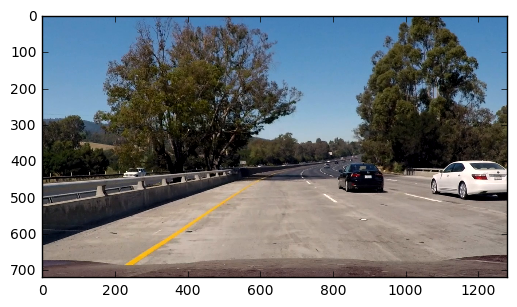

In [176]:
#reading in an image

#image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = VideoFileClip('challenge.mp4').get_frame(5)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

(100, 600, 3)


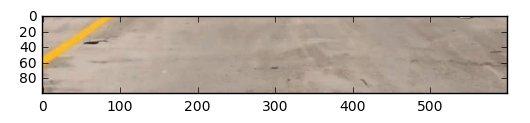

In [177]:
#test cell to remove
#plt.imshow(image)
x_center = image.shape[1]/2

crop_y_t = 560
crop_y_l = 660
crop_x_r = x_center+300
crop_x_l = x_center-300

#crop_y_t = 560
#crop_y_l = 660
#crop_x_r = x_center+500
#crop_x_l = x_center-500


crop_img = image[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
plt.imshow(crop_img)
print(crop_img.shape)

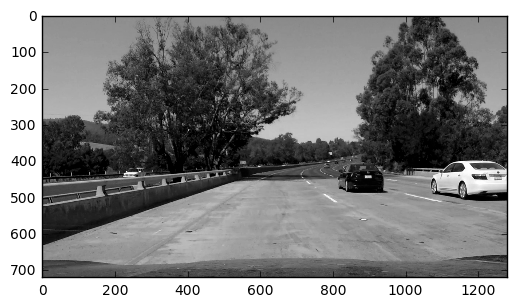

In [178]:
#reduce colored image to grayscaled image
image_grayed = grayscale(image)
plt.imshow(image_grayed, cmap='gray')

7


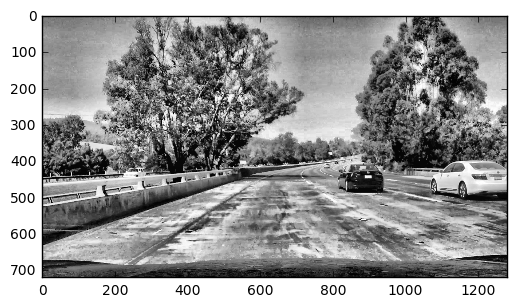

In [179]:
#apply CLAHE
clahe_params = clahe_auto_params(image_grayed)
#image_clahe = CLAHE_img(image_grayed,clahe_params[0],clahe_params[1])
image_clahe = CLAHE_img(image_grayed,7,clahe_params[1])
plt.imshow(image_clahe, cmap='gray')
print(clahe_params[0])

(207.78841285714284, 255)


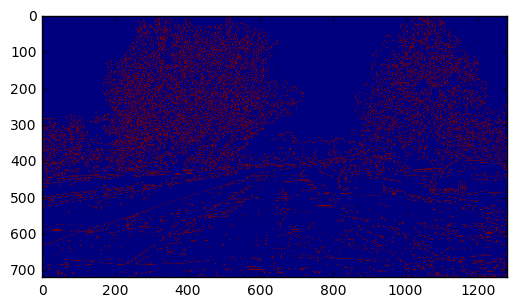

In [180]:
#apply canny to grayscaled image
canny_threshold = canny_auto_threshold(image_clahe)
image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
print(canny_threshold)
plt.imshow(image_canny)

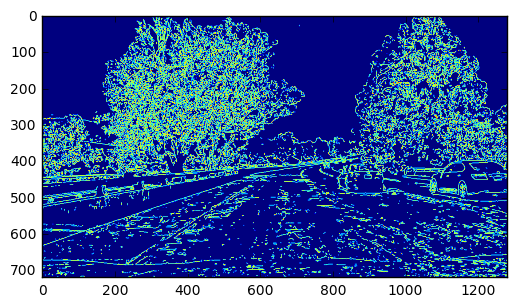

In [181]:
#apply gaussian blur to image
kernel_size = 3
image_gauss = gaussian_blur(image_canny,kernel_size)
plt.imshow(image_gauss)

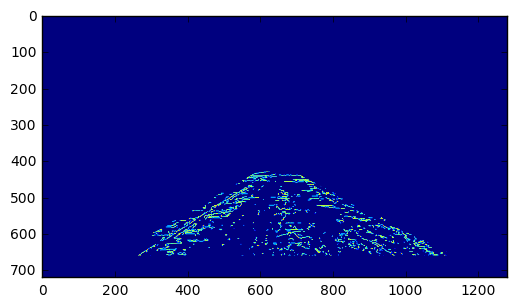

In [182]:
#pick area of interest
x_center = image.shape[1] / 2
top_left_v = (x_center-50,430)
low_left_v = (200,image.shape[0]-60)
top_right_v = (x_center+50,430)
low_right_v = (image.shape[1] - 150,image.shape[0]-60)
vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
image_mask = region_of_interest(image_gauss,vertices)
plt.imshow(image_mask)

right lane slopes: [0.55405405405405406, 0.65517241379310343]
720 451 0.604613233924 709
left lane slopes: [-0.625]
[(169, 720), (440, 551), (169, 720), (440, 551)]


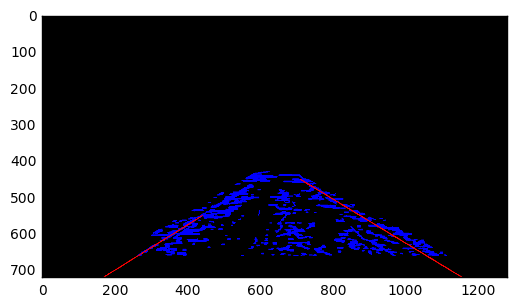

In [228]:
#determine hough lines
lines_hough = hough_lines(image_mask,0.5, np.pi/180, 20, 5, 5,right_left_lanes)
plt.imshow(lines_hough)

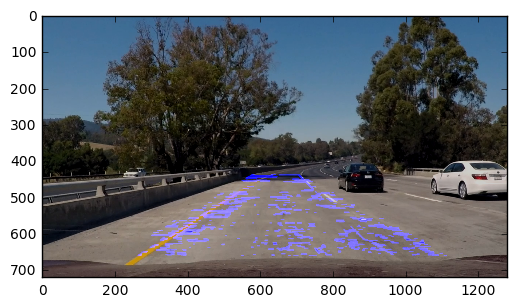

In [219]:
#Add weighed lines onto initial image
image_final = weighted_img(lines_hough,image)
plt.imshow(image_final)

In [233]:
def process_image(image):
    
    image_grayed = grayscale(image)
    clahe_params = clahe_auto_params(image_grayed)
    image_clahe = CLAHE_img(image_grayed,clahe_params[0],clahe_params[1])
    canny_threshold = canny_auto_threshold(image_clahe)
    image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
    kernel_size = 3
    image_gauss = gaussian_blur(image_canny,kernel_size)
    x_center = image.shape[1] / 2
    top_left_v = (x_center-50,430)
    low_left_v = (200,image.shape[0]-60)
    top_right_v = (x_center+50,430)
    low_right_v = (image.shape[1] - 150,image.shape[0]-60)
    vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
    image_mask = region_of_interest(image_gauss,vertices)
    lines_hough = hough_lines(image_mask,0.5, np.pi/180, 40, 4, 4,right_left_lanes)
    image_final = weighted_img(lines_hough,image)
    plt.imshow(image_final)
        
    return image_final

right lane slopes: [0.55214723926380371, 0.60139860139860135, 0.75, 0.55128205128205132, 0.60305343511450382, 0.55214723926380371, 0.54838709677419351, 0.61538461538461542, 0.61290322580645162, 0.55000000000000004, 0.5535714285714286, 0.55303030303030298, 0.70588235294117652, 0.59340659340659341, 0.59322033898305082, 0.66666666666666663, 0.66666666666666663, 0.61764705882352944, 0.68000000000000005, 0.66666666666666663, 0.75, 0.55555555555555558, 0.66666666666666663, 0.61290322580645162, 0.7142857142857143, 0.66666666666666663, 0.60305343511450382, 0.66666666666666663, 0.6333333333333333, 0.53731343283582089, 0.70370370370370372, 0.55882352941176472, 0.61616161616161613, 0.80000000000000004, 0.65625, 0.59259259259259256, 0.66666666666666663, 0.73076923076923073, 0.7142857142857143, 0.7142857142857143, 0.70588235294117652, 0.59999999999999998, 0.68965517241379315, 0.71111111111111114, 0.69230769230769229, 0.53125, 0.55000000000000004, 0.69999999999999996]
720 443 0.636951070284 710
left

  0%|          | 0/251 [00:00<?, ?it/s]

right lane slopes: [0.55214723926380371, 0.60139860139860135, 0.75, 0.55128205128205132, 0.60305343511450382, 0.55214723926380371, 0.54838709677419351, 0.61538461538461542, 0.61290322580645162, 0.55000000000000004, 0.5535714285714286, 0.55303030303030298, 0.70588235294117652, 0.59340659340659341, 0.59322033898305082, 0.66666666666666663, 0.66666666666666663, 0.61764705882352944, 0.68000000000000005, 0.66666666666666663, 0.75, 0.55555555555555558, 0.66666666666666663, 0.61290322580645162, 0.7142857142857143, 0.66666666666666663, 0.60305343511450382, 0.66666666666666663, 0.6333333333333333, 0.53731343283582089, 0.70370370370370372, 0.55882352941176472, 0.61616161616161613, 0.80000000000000004, 0.65625, 0.59259259259259256, 0.66666666666666663, 0.73076923076923073, 0.7142857142857143, 0.7142857142857143, 0.70588235294117652, 0.59999999999999998, 0.68965517241379315, 0.71111111111111114, 0.69230769230769229, 0.53125, 0.55000000000000004, 0.69999999999999996]
720 443 0.636951070284 710
left

  0%|          | 1/251 [00:00<00:27,  9.15it/s]

right lane slopes: [0.5714285714285714, 0.59999999999999998, 0.62068965517241381, 0.63157894736842102, 0.57692307692307687, 0.65714285714285714, 0.6179775280898876, 0.58181818181818179, 0.57692307692307687, 0.66666666666666663, 0.5714285714285714, 0.62222222222222223, 0.60526315789473684, 0.61111111111111116, 0.65217391304347827, 0.57425742574257421, 0.55384615384615388, 0.6428571428571429, 0.63636363636363635, 0.63076923076923075, 0.625, 0.58536585365853655, 0.66666666666666663, 0.59999999999999998, 0.65217391304347827, 0.6097560975609756, 0.58620689655172409, 0.63888888888888884, 0.61363636363636365, 0.70370370370370372, 0.75, 0.63636363636363635, 0.625, 0.66666666666666663, 0.66666666666666663, 0.59999999999999998, 0.6428571428571429, 0.59999999999999998, 0.61538461538461542, 0.63076923076923075, 0.61538461538461542, 0.66666666666666663, 0.61111111111111116, 0.5757575757575758, 0.61538461538461542, 0.58620689655172409, 0.67741935483870963, 0.57317073170731703, 0.5714285714285714, 0.

  1%|          | 2/251 [00:00<00:27,  9.10it/s]

right lane slopes: [0.62857142857142856, 0.6333333333333333, 0.625, 0.60606060606060608, 0.5757575757575758, 0.63636363636363635, 0.5757575757575758, 0.66666666666666663, 0.62068965517241381, 0.61290322580645162, 0.5641025641025641, 0.5714285714285714, 0.56666666666666665, 0.55263157894736847]
720 446 0.602566648902 714
left lane slopes: [-0.67432950191570884, -0.67132867132867136, -0.70476190476190481, -0.67171717171717171, -0.67123287671232879, -0.70270270270270274, -0.67317073170731712, -0.69999999999999996]
[(211, 720), (580, 468), (211, 720), (580, 468)]
right lane slopes: [0.62857142857142856, 0.68000000000000005, 0.65625, 0.76666666666666672, 0.62857142857142856]
720 447 0.672011904762 714
left lane slopes: [-0.65217391304347827, -0.68253968253968256, -0.67924528301886788, -0.70175438596491224, -0.69230769230769229, -0.67741935483870963, -0.6271186440677966, -0.65517241379310343, -0.62666666666666671]
[(208, 720), (576, 475), (208, 720), (576, 475)]


  2%|▏         | 4/251 [00:00<00:24,  9.91it/s]

right lane slopes: [0.6428571428571429, 0.66666666666666663, 0.60563380281690138, 0.64444444444444449, 0.66666666666666663, 0.58441558441558439, 0.64000000000000001, 0.66666666666666663, 0.62068965517241381, 0.66666666666666663, 0.63492063492063489, 0.625, 0.69230769230769229, 0.59999999999999998, 0.5714285714285714, 0.69999999999999996, 0.62222222222222223, 0.61016949152542377, 0.63157894736842102, 0.58823529411764708, 0.63414634146341464, 0.5757575757575758, 0.66666666666666663, 0.66666666666666663, 0.61363636363636365, 0.67647058823529416, 0.65384615384615385, 0.58823529411764708, 0.625, 0.66666666666666663, 0.625, 0.66666666666666663, 0.66666666666666663, 0.625, 0.65625, 0.59999999999999998, 0.62857142857142856, 0.58620689655172409, 0.59999999999999998, 0.5757575757575758, 0.625, 0.75, 0.62068965517241381, 0.63636363636363635, 0.66666666666666663, 0.59999999999999998, 0.59090909090909094, 0.625]
720 446 0.633175223972 712
left lane slopes: [-0.67000000000000004, -0.7448979591836735

  2%|▏         | 6/251 [00:00<00:24, 10.12it/s]

right lane slopes: [0.60176991150442483, 0.55555555555555558, 0.65454545454545454, 0.58333333333333337, 0.58904109589041098, 0.66666666666666663, 0.65625, 0.62962962962962965, 0.57894736842105265, 0.75, 0.65217391304347827, 0.61538461538461542, 0.61904761904761907, 0.69999999999999996, 0.66666666666666663, 0.5757575757575758, 0.58730158730158732, 0.58333333333333337, 0.57692307692307687, 0.59459459459459463, 0.6333333333333333, 0.62068965517241381, 0.63157894736842102, 0.57999999999999996, 0.65909090909090906, 0.63829787234042556, 0.61290322580645162, 0.625, 0.66666666666666663, 0.59999999999999998, 0.63636363636363635, 0.59999999999999998, 0.62962962962962965, 0.66666666666666663, 0.625, 0.59459459459459463, 0.5714285714285714, 0.59259259259259256, 0.5625, 0.63636363636363635, 0.58333333333333337, 0.68085106382978722, 0.59999999999999998, 0.5714285714285714, 0.6428571428571429, 0.69999999999999996]
720 441 0.621697653184 711
left lane slopes: [-0.72623574144486691, -0.7192982456140351

  3%|▎         | 8/251 [00:00<00:22, 10.83it/s]

right lane slopes: [0.64615384615384619, 0.66666666666666663, 0.61538461538461542, 0.67796610169491522, 0.65714285714285714, 0.59999999999999998, 0.64615384615384619, 0.66666666666666663, 0.6875, 0.63157894736842102, 0.67241379310344829, 0.6607142857142857, 0.61538461538461542, 0.6428571428571429]
720 446 0.649041670307 716
left lane slopes: [-0.67484662576687116, -0.67708333333333337, -0.72727272727272729, -0.72549019607843135, -0.67647058823529416, -0.66666666666666663, -0.7142857142857143, -0.78260869565217395, -0.67532467532467533, -0.72727272727272729, -0.71666666666666667, -0.66666666666666663, -0.66666666666666663]
[(222, 720), (585, 466), (222, 720), (585, 466)]
right lane slopes: [0.59999999999999998, 0.66666666666666663, 0.61538461538461542, 0.62790697674418605, 0.66666666666666663, 0.60144927536231885, 0.58139534883720934, 0.6470588235294118, 0.59999999999999998, 0.66666666666666663, 0.57746478873239437, 0.65714285714285714, 0.63636363636363635, 0.61290322580645162, 0.666666

  4%|▍         | 10/251 [00:00<00:21, 11.06it/s]

right lane slopes: [0.59999999999999998, 0.62445414847161573, 0.57692307692307687, 0.62445414847161573, 0.57446808510638303, 0.62666666666666671, 0.62773722627737227, 0.58333333333333337, 0.62585034013605445, 0.56000000000000005, 0.56521739130434778, 0.57777777777777772, 0.6271186440677966, 0.580952380952381, 0.58139534883720934, 0.56818181818181823, 0.59090909090909094, 0.57499999999999996, 0.58823529411764708, 0.63829787234042556, 0.59999999999999998, 0.62222222222222223, 0.5714285714285714, 0.62765957446808507, 0.57894736842105265, 0.64864864864864868, 0.58333333333333337, 0.59090909090909094, 0.6071428571428571, 0.57446808510638303, 0.6470588235294118, 0.63636363636363635, 0.59999999999999998, 0.58823529411764708, 0.62790697674418605, 0.59999999999999998, 0.61904761904761907, 0.6216216216216216, 0.58333333333333337, 0.59999999999999998, 0.57692307692307687, 0.66666666666666663, 0.5625, 0.57894736842105265, 0.58333333333333337]
720 453 0.600303781015 720
left lane slopes: [-0.757575

  5%|▍         | 12/251 [00:01<00:21, 11.20it/s]

right lane slopes: [0.6071428571428571, 0.59813084112149528, 0.62420382165605093, 0.620253164556962, 0.625, 0.55555555555555558, 0.58333333333333337, 0.58823529411764708, 0.59880239520958078, 0.59999999999999998, 0.62337662337662336, 0.62195121951219512, 0.57377049180327866, 0.61111111111111116, 0.55555555555555558, 0.64864864864864868, 0.55555555555555558, 0.59139784946236562, 0.6428571428571429, 0.59880239520958078, 0.63636363636363635, 0.65217391304347827, 0.60465116279069764, 0.57692307692307687, 0.5636363636363636, 0.66666666666666663, 0.59999999999999998, 0.63414634146341464, 0.62420382165605093, 0.57894736842105265, 0.58333333333333337, 0.59649122807017541, 0.55263157894736847, 0.66666666666666663, 0.63636363636363635, 0.54545454545454541, 0.66666666666666663, 0.59999999999999998, 0.61904761904761907, 0.59999999999999998, 0.7142857142857143, 0.65217391304347827, 0.55000000000000004, 0.68181818181818177, 0.6428571428571429, 0.54545454545454541, 0.625, 0.57894736842105265]
720 446

  6%|▌         | 14/251 [00:01<00:21, 11.13it/s]

right lane slopes: [0.66666666666666663, 0.63157894736842102, 0.58620689655172409, 0.53846153846153844, 0.625, 0.55882352941176472, 0.625, 0.55882352941176472, 0.58823529411764708, 0.58333333333333337]
720 456 0.596212973532 726
left lane slopes: [-0.69999999999999996, -0.72777777777777775, -0.69999999999999996, -0.70238095238095233, -0.72549019607843135, -0.79411764705882348, -0.80000000000000004, -0.72727272727272729, -0.78787878787878785, -0.66666666666666663, -0.73529411764705888, -0.72727272727272729, -0.7857142857142857, -0.83333333333333337, -0.83333333333333337]
[(243, 720), (585, 464), (243, 720), (585, 464)]
right lane slopes: [0.75, 0.65714285714285714, 0.67647058823529416, 0.66666666666666663, 0.66666666666666663, 0.79166666666666663, 0.62857142857142856]
720 444 0.691026410564 715
left lane slopes: [-0.70108695652173914, -0.69963369963369959, -0.69999999999999996, -0.78947368421052633, -0.70192307692307687, -0.75, -0.75]
[(232, 720), (579, 468), (232, 720), (579, 468)]


  6%|▋         | 16/251 [00:01<00:20, 11.43it/s]

right lane slopes: [0.6705882352941176, 0.67441860465116277, 0.65384615384615385, 0.66666666666666663, 0.64583333333333337, 0.65853658536585369, 0.69047619047619047, 0.625, 0.63636363636363635, 0.67647058823529416, 0.63636363636363635, 0.66666666666666663, 0.625, 0.78125, 0.59999999999999998, 0.69999999999999996, 0.67500000000000004, 0.68181818181818177, 0.63157894736842102, 0.75, 0.67647058823529416, 0.63636363636363635, 0.63829787234042556, 0.72727272727272729, 0.68965517241379315, 0.68965517241379315, 0.63636363636363635, 0.5714285714285714, 0.63636363636363635, 0.65217391304347827, 0.61111111111111116, 0.7142857142857143]
720 444 0.663291224315 715
left lane slopes: [-0.75352112676056338, -0.72666666666666668, -0.70238095238095233, -0.69680851063829785, -0.7021276595744681, -0.70056497175141241, -0.81818181818181823, -0.676056338028169, -0.6785714285714286, -0.73148148148148151, -0.70329670329670335, -0.625, -0.68421052631578949, -0.69999999999999996, -0.8571428571428571, -0.800000

  7%|▋         | 18/251 [00:01<00:20, 11.54it/s]

right lane slopes: [0.6428571428571429, 0.63157894736842102, 0.65079365079365081, 0.61904761904761907, 0.6875, 0.61956521739130432, 0.63636363636363635, 0.63636363636363635, 0.65306122448979587, 0.7441860465116279, 0.7142857142857143, 0.62264150943396224, 0.73684210526315785, 0.61538461538461542, 0.65000000000000002, 0.6428571428571429, 0.73684210526315785, 0.62903225806451613, 0.625, 0.66666666666666663, 0.76000000000000001, 0.59999999999999998, 0.77777777777777779, 0.7407407407407407, 0.80000000000000004, 0.65306122448979587, 0.65000000000000002, 0.7857142857142857, 0.70833333333333337, 0.62, 0.78260869565217395, 0.61538461538461542, 0.6428571428571429, 0.72727272727272729, 0.77142857142857146, 0.76470588235294112, 0.6428571428571429, 0.63636363636363635, 0.6875, 0.75, 0.64150943396226412]
720 445 0.68095084021 715
left lane slopes: [-0.7531380753138075, -0.75454545454545452, -0.72440944881889768, -0.70129870129870131, -0.68292682926829273, -0.7531380753138075, -0.69565217391304346, 

  8%|▊         | 20/251 [00:01<00:19, 11.72it/s]

right lane slopes: [0.6428571428571429, 0.62096774193548387, 0.64197530864197527, 0.625, 0.6071428571428571, 0.61428571428571432, 0.58823529411764708, 0.59302325581395354, 0.66666666666666663, 0.61111111111111116, 0.75, 0.59090909090909094, 0.6428571428571429, 0.59756097560975607, 0.625, 0.64583333333333337, 0.66666666666666663, 0.65151515151515149, 0.58823529411764708, 0.5977011494252874, 0.5714285714285714, 0.60273972602739723, 0.66666666666666663, 0.72727272727272729, 0.6428571428571429, 0.7142857142857143, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.625, 0.65116279069767447, 0.69565217391304346, 0.625, 0.60273972602739723, 0.66666666666666663, 0.59999999999999998, 0.61538461538461542, 0.58333333333333337, 0.57894736842105265]
720 446 0.630083694666 714
left lane slopes: [-0.75217391304347825, -0.72641509433962259, -0.72614107883817425, -0.73170731707317072, -0.75545851528384278, -0.7816091954022989, -0.726457399103139, -0.72350230414746541,

  9%|▉         | 22/251 [00:01<00:19, 11.75it/s]

right lane slopes: [0.66666666666666663, 0.62411347517730498, 0.57718120805369133, 0.64634146341463417, 0.625, 0.57823129251700678, 0.62773722627737227, 0.57823129251700678, 0.6071428571428571, 0.5714285714285714, 0.61627906976744184, 0.7407407407407407, 0.58064516129032262, 0.62105263157894741, 0.65000000000000002, 0.75, 0.66666666666666663, 0.7407407407407407, 0.72549019607843135, 0.6607142857142857, 0.65714285714285714, 0.59999999999999998, 0.57446808510638303, 0.56521739130434778, 0.68421052631578949, 0.6428571428571429, 0.7407407407407407, 0.59999999999999998, 0.75]
720 444 0.643760009974 714
left lane slopes: [-0.75111111111111106, -0.75111111111111106, -0.75336322869955152, -0.7007299270072993, -0.75, -0.75, -0.75362318840579712, -0.69633507853403143, -0.73333333333333328, -0.78021978021978022, -0.74137931034482762, -0.76666666666666672, -0.76923076923076927, -0.69230769230769229, -0.75, -0.73333333333333328, -0.76190476190476186, -0.75, -0.75409836065573765, -0.7619047619047618

 10%|▉         | 24/251 [00:02<00:19, 11.35it/s]

right lane slopes: [0.62091503267973858, 0.55376344086021501, 0.62179487179487181, 0.6333333333333333, 0.62068965517241381, 0.55483870967741933, 0.62666666666666671, 0.55487804878048785, 0.65454545454545454, 0.52173913043478259, 0.56000000000000005, 0.63888888888888884, 0.55660377358490565, 0.59999999999999998, 0.62790697674418605, 0.5547945205479452, 0.65217391304347827, 0.54545454545454541, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.55555555555555558, 0.66666666666666663, 0.65306122448979587, 0.74285714285714288, 0.6428571428571429, 0.55555555555555558, 0.69999999999999996, 0.7142857142857143, 0.625, 0.68421052631578949, 0.84999999999999998, 0.69696969696969702, 0.5714285714285714, 0.8214285714285714, 0.75, 0.64000000000000001, 0.75, 0.60869565217391308]
720 445 0.635749375627 714
left lane slopes: [-0.72511848341232232, -0.72789115646258506, -0.73255813953488369, -0.72727272727272729, -0.73684210526315785, -0.75, -0.75, -0.71084337349397586, -0.7248322147651006

 10%|█         | 26/251 [00:02<00:20, 11.08it/s]

right lane slopes: [0.64516129032258063, 0.65517241379310343, 0.75, 0.7142857142857143, 0.54545454545454541, 0.69565217391304346, 0.66666666666666663, 0.5625]
720 448 0.654361600554 716
left lane slopes: [-0.70036101083032487, -0.70085470085470081, -0.69999999999999996, -0.75369458128078815, -0.69999999999999996, -0.75510204081632648, -0.69999999999999996, -0.67241379310344829, -0.70068027210884354, -0.69999999999999996]
[(223, 720), (585, 464), (223, 720), (585, 464)]
right lane slopes: [0.64492753623188404, 0.6428571428571429, 0.640625, 0.625, 0.73469387755102045, 0.61111111111111116, 0.66666666666666663, 0.77272727272727271, 0.6875, 0.65079365079365081, 0.65000000000000002, 0.69767441860465118, 0.61764705882352944, 0.67567567567567566, 0.61764705882352944, 0.70588235294117652, 0.68181818181818177, 0.71052631578947367, 0.75, 0.66666666666666663, 0.75, 0.72727272727272729, 0.75, 0.76923076923076927, 0.625, 0.625, 0.69999999999999996, 0.59999999999999998, 0.61764705882352944, 0.5909090

 11%|█         | 28/251 [00:02<00:19, 11.19it/s]

right lane slopes: [0.75, 0.61764705882352944, 0.61538461538461542, 0.67741935483870963, 0.65000000000000002, 0.62068965517241381, 0.6333333333333333, 0.61904761904761907, 0.63043478260869568, 0.65517241379310343, 0.6785714285714286, 0.7142857142857143, 0.63636363636363635, 0.72727272727272729, 0.66666666666666663, 0.59999999999999998, 0.72413793103448276, 0.65217391304347827, 0.63636363636363635, 0.67741935483870963, 0.59999999999999998, 0.66666666666666663, 0.625, 0.67741935483870963, 0.67241379310344829, 0.65217391304347827, 0.67441860465116277, 0.66666666666666663, 0.61111111111111116, 0.61904761904761907, 0.63636363636363635, 0.66666666666666663, 0.69565217391304346, 0.5714285714285714, 0.69230769230769229, 0.65000000000000002, 0.66666666666666663, 0.6875, 0.61538461538461542, 0.625]
720 446 0.653856789833 714
left lane slopes: [-0.73076923076923073, -0.75, -0.75324675324675328, -0.69961977186311786, -0.75225225225225223, -0.75609756097560976, -0.66666666666666663, -0.777777777777

 12%|█▏        | 30/251 [00:02<00:20, 11.04it/s]

right lane slopes: [0.66000000000000003, 0.6875, 0.64516129032258063, 0.69811320754716977, 0.68000000000000005, 0.66666666666666663, 0.63636363636363635, 0.625, 0.60869565217391308, 0.66666666666666663, 0.6470588235294118, 0.6428571428571429, 0.70588235294117652, 0.6875, 0.68965517241379315, 0.66666666666666663, 0.68181818181818177, 0.7142857142857143, 0.68627450980392157, 0.7021276595744681, 0.75, 0.67391304347826086, 0.66666666666666663, 0.6470588235294118, 0.7142857142857143, 0.7142857142857143, 0.67741935483870963, 0.6470588235294118, 0.6875, 0.6875, 0.69999999999999996, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.69230769230769229, 0.69999999999999996, 0.69047619047619047, 0.7142857142857143, 0.67741935483870963, 0.59090909090909094, 0.75, 0.65517241379310343, 0.75, 0.59999999999999998, 0.66666666666666663, 0.6428571428571429, 0.7142857142857143, 0.6875, 0.69999999999999996, 0.61904761904761907, 0.7142857142857143, 0.75]
720 443 0.675881951244 715
left lane sl

 13%|█▎        | 32/251 [00:02<00:18, 11.59it/s]

right lane slopes: [0.65217391304347827, 0.65217391304347827, 0.69841269841269837, 0.64102564102564108, 0.59999999999999998, 0.70491803278688525, 0.69999999999999996, 0.65000000000000002, 0.69999999999999996, 0.7142857142857143, 0.59999999999999998, 0.64406779661016944, 0.65151515151515149, 0.66666666666666663]
720 452 0.662517109099 719
left lane slopes: [-0.69874476987447698, -0.7279411764705882, -0.69731800766283525, -0.72872340425531912, -0.69999999999999996, -0.72222222222222221, -0.69803921568627447, -0.7303370786516854, -0.69999999999999996, -0.80000000000000004, -0.69999999999999996, -0.69444444444444442, -0.71052631578947367, -0.75, -0.83333333333333337]
[(232, 720), (577, 470), (232, 720), (577, 470)]
right lane slopes: [0.65957446808510634, 0.61290322580645162, 0.647887323943662, 0.5714285714285714, 0.61971830985915488, 0.65079365079365081, 0.66666666666666663, 0.6875, 0.66666666666666663, 0.6428571428571429, 0.59999999999999998, 0.69863013698630139, 0.63380281690140849, 0.6

 14%|█▎        | 34/251 [00:02<00:19, 11.40it/s]

right lane slopes: [0.59999999999999998, 0.68421052631578949, 0.69999999999999996, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.66666666666666663, 0.5714285714285714, 0.64179104477611937, 0.59090909090909094, 0.68181818181818177, 0.59259259259259256, 0.65000000000000002, 0.625, 0.61111111111111116, 0.66666666666666663, 0.62650602409638556, 0.63636363636363635, 0.5714285714285714, 0.70370370370370372, 0.6428571428571429, 0.55555555555555558, 0.70588235294117652, 0.72222222222222221, 0.59999999999999998, 0.5714285714285714, 0.68000000000000005, 0.57894736842105265, 0.69999999999999996, 0.6470588235294118, 0.75, 0.75, 0.58333333333333337, 0.59999999999999998, 0.63157894736842102, 0.70588235294117652, 0.65000000000000002, 0.59999999999999998, 0.60344827586206895, 0.66666666666666663]
720 448 0.640793116692 715
left lane slopes: [-0.72268907563025209, -0.72807017543859653, -0.67142857142857137, -0.71875, -0.67500000000000004, -0.72580645161290325, -0.6741573033707865, -0

 14%|█▍        | 36/251 [00:03<00:19, 11.10it/s]

right lane slopes: [0.57627118644067798, 0.68571428571428572, 0.57541899441340782, 0.6428571428571429, 0.56000000000000005, 0.6518518518518519, 0.67164179104477617, 0.5714285714285714, 0.64130434782608692, 0.5714285714285714, 0.58620689655172409, 0.6470588235294118, 0.59090909090909094, 0.57541899441340782, 0.66666666666666663, 0.58333333333333337, 0.59999999999999998, 0.54054054054054057, 0.59090909090909094, 0.66666666666666663, 0.63636363636363635, 0.5714285714285714, 0.61538461538461542, 0.59259259259259256, 0.71999999999999997, 0.63636363636363635, 0.61538461538461542, 0.57999999999999996, 0.58536585365853655, 0.61538461538461542, 0.6428571428571429, 0.59999999999999998, 0.59999999999999998, 0.57627118644067798, 0.66666666666666663, 0.59999999999999998, 0.70967741935483875, 0.57333333333333336]
720 445 0.614018440309 713
left lane slopes: [-0.6717557251908397, -0.67432950191570884, -0.67391304347826086, -0.70270270270270274, -0.70434782608695656, -0.70422535211267601, -0.703703703

 15%|█▌        | 38/251 [00:03<00:19, 10.87it/s]

right lane slopes: [0.6470588235294118, 0.61764705882352944, 0.63636363636363635, 0.59999999999999998, 0.60606060606060608, 0.64516129032258063, 0.60606060606060608, 0.59999999999999998, 0.64000000000000001]
720 450 0.622039113462 717
left lane slopes: [-0.64953271028037385, -0.65340909090909094, -0.64848484848484844, -0.68000000000000005, -0.64864864864864868, -0.66666666666666663, -0.65217391304347827, -0.65277777777777779, -0.68041237113402064, -0.67796610169491522, -0.64864864864864868, -0.65000000000000002, -0.68918918918918914]
[(202, 720), (587, 466), (202, 720), (587, 466)]
right lane slopes: [0.625, 0.59999999999999998, 0.64516129032258063, 0.59999999999999998, 0.60416666666666663, 0.625, 0.64516129032258063, 0.62650602409638556, 0.65000000000000002, 0.62068965517241381, 0.64000000000000001, 0.61538461538461542, 0.65217391304347827, 0.64000000000000001, 0.69999999999999996, 0.68421052631578949, 0.6097560975609756, 0.6166666666666667, 0.6097560975609756, 0.59183673469387754, 0.

 16%|█▌        | 40/251 [00:03<00:19, 10.97it/s]

right lane slopes: [0.61538461538461542, 0.64583333333333337, 0.63953488372093026, 0.640625, 0.65714285714285714, 0.64473684210526316, 0.58333333333333337, 0.60869565217391308, 0.66666666666666663, 0.66666666666666663, 0.5625, 0.6097560975609756, 0.62745098039215685, 0.6607142857142857, 0.66666666666666663, 0.58139534883720934, 0.59999999999999998, 0.62745098039215685, 0.61538461538461542, 0.61538461538461542, 0.66666666666666663, 0.58181818181818179, 0.625, 0.68571428571428572, 0.66666666666666663, 0.64000000000000001, 0.6216216216216216, 0.70588235294117652, 0.6785714285714286, 0.61538461538461542, 0.64367816091954022]
720 442 0.634397658747 713
left lane slopes: [-0.69354838709677424, -0.67391304347826086, -0.70068027210884354, -0.63157894736842102, -0.69230769230769229, -0.6785714285714286, -0.73684210526315785, -0.67567567567567566, -0.7142857142857143, -0.72549019607843135, -0.70652173913043481, -0.7570093457943925, -0.68181818181818177, -0.65625, -0.70909090909090911, -0.6363636

 17%|█▋        | 42/251 [00:03<00:19, 10.79it/s]

right lane slopes: [0.63793103448275867, 0.6166666666666667, 0.59259259259259256, 0.61290322580645162, 0.5714285714285714, 0.6071428571428571, 0.61538461538461542, 0.59259259259259256, 0.61904761904761907, 0.66666666666666663, 0.58730158730158732, 0.59375, 0.59615384615384615, 0.5714285714285714, 0.62068965517241381, 0.61904761904761907, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.6333333333333333, 0.66666666666666663, 0.58620689655172409, 0.59999999999999998, 0.62068965517241381, 0.58974358974358976, 0.63636363636363635, 0.59999999999999998, 0.625, 0.66666666666666663, 0.61538461538461542, 0.59999999999999998, 0.7142857142857143, 0.62790697674418605]
720 450 0.617261882985 719
left lane slopes: [-0.70124481327800825, -0.6730038022813688, -0.67355371900826444, -0.67317073170731712, -0.72891566265060237, -0.67500000000000004, -0.67403314917127077, -0.70068027210884354, -0.75806451612903225, -0.7142857142857143, -0.72727272727272729, -0.63636363636363635, -0.73214285

 18%|█▊        | 44/251 [00:03<00:19, 10.84it/s]

right lane slopes: [0.6495726495726496, 0.61702127659574468, 0.59340659340659341, 0.625, 0.61111111111111116, 0.625, 0.65384615384615385, 0.61643835616438358, 0.64000000000000001, 0.55696202531645567, 0.625, 0.59999999999999998, 0.60784313725490191, 0.625, 0.59999999999999998, 0.62068965517241381, 0.65909090909090906, 0.67307692307692313, 0.6875, 0.62337662337662336, 0.6071428571428571, 0.59999999999999998, 0.5714285714285714, 0.68965517241379315, 0.63636363636363635, 0.59999999999999998, 0.58333333333333337, 0.69999999999999996, 0.55000000000000004, 0.6470588235294118, 0.66666666666666663, 0.55555555555555558, 0.61538461538461542, 0.59999999999999998, 0.66666666666666663, 0.61643835616438358, 0.625, 0.63636363636363635, 0.61290322580645162, 0.59999999999999998, 0.56862745098039214, 0.7142857142857143, 0.59999999999999998, 0.62745098039215685, 0.59999999999999998, 0.61538461538461542]
720 453 0.622079245475 722
left lane slopes: [-0.72727272727272729, -0.72368421052631582, -0.716049382

 19%|█▉        | 48/251 [00:04<00:20,  9.72it/s]

right lane slopes: [0.55555555555555558, 0.64539007092198586, 0.55844155844155841, 0.55555555555555558, 0.55214723926380371, 0.68627450980392157, 0.69565217391304346, 0.62393162393162394, 0.550561797752809, 0.61728395061728392, 0.69230769230769229, 0.58333333333333337, 0.66666666666666663, 0.69090909090909092, 0.55555555555555558, 0.6428571428571429, 0.5544554455445545, 0.66666666666666663, 0.5357142857142857, 0.63157894736842102, 0.70588235294117652, 0.64761904761904765, 0.71999999999999997, 0.6333333333333333, 0.6875, 0.57894736842105265, 0.59999999999999998, 0.7142857142857143, 0.70370370370370372, 0.64516129032258063, 0.72727272727272729, 0.6470588235294118, 0.6875, 0.66666666666666663, 0.69999999999999996, 0.5490196078431373, 0.64864864864864868]
720 446 0.635768598575 717
left lane slopes: [-0.67391304347826086, -0.69960474308300391, -0.70114942528735635, -0.76470588235294112, -0.75324675324675328, -0.72380952380952379, -0.74489795918367352, -0.73584905660377353, -0.7023809523809

 20%|█▉        | 50/251 [00:04<00:19, 10.21it/s]

right lane slopes: [0.55072463768115942, 0.63636363636363635, 0.625, 0.62, 0.64864864864864868, 0.55000000000000004, 0.6428571428571429, 0.59999999999999998, 0.69999999999999996, 0.65384615384615385, 0.65116279069767447, 0.55102040816326525, 0.61538461538461542, 0.75, 0.65909090909090906, 0.59999999999999998, 0.69999999999999996, 0.6292134831460674, 0.5625, 0.55555555555555558, 0.59259259259259256, 0.66666666666666663, 0.65277777777777779, 0.59999999999999998, 0.55789473684210522, 0.65217391304347827, 0.59999999999999998, 0.66666666666666663, 0.56000000000000005, 0.55555555555555558, 0.63636363636363635, 0.56521739130434778, 0.6071428571428571, 0.7142857142857143, 0.66666666666666663, 0.75, 0.53448275862068961, 0.66666666666666663, 0.55882352941176472]
720 446 0.623213977206 716
left lane slopes: [-0.6987951807228916, -0.69999999999999996, -0.67295597484276726, -0.68292682926829273, -0.63636363636363635, -0.67625899280575541, -0.70476190476190481, -0.6875, -0.69090909090909092, -0.6793

 21%|██        | 53/251 [00:04<00:21,  9.11it/s]

right lane slopes: [0.59090909090909094, 0.6071428571428571, 0.6428571428571429, 0.67647058823529416, 0.63157894736842102, 0.57499999999999996, 0.58974358974358976, 0.59999999999999998, 0.60465116279069764, 0.58620689655172409, 0.60655737704918034, 0.59375, 0.59302325581395354, 0.59999999999999998, 0.64000000000000001, 0.6216216216216216, 0.60869565217391308, 0.58490566037735847, 0.59090909090909094, 0.66666666666666663, 0.66666666666666663, 0.5714285714285714, 0.625, 0.59999999999999998, 0.63636363636363635, 0.59999999999999998, 0.65384615384615385, 0.61111111111111116, 0.625, 0.59090909090909094, 0.5714285714285714, 0.61538461538461542, 0.66666666666666663, 0.55555555555555558, 0.60606060606060608, 0.59999999999999998, 0.66666666666666663, 0.60256410256410253, 0.60465116279069764, 0.53333333333333333, 0.59999999999999998, 0.63636363636363635, 0.6216216216216216]
720 437 0.610960729511 696
left lane slopes: [-0.6988847583643123, -0.72580645161290325, -0.72151898734177211, -0.697297297

 22%|██▏       | 54/251 [00:05<00:21,  9.29it/s]

right lane slopes: [0.625, 0.5714285714285714, 0.75, 0.6271186440677966, 0.62068965517241381, 0.6428571428571429, 0.62352941176470589, 0.66666666666666663, 0.61538461538461542, 0.57692307692307687, 0.62962962962962965, 0.61111111111111116, 0.59999999999999998, 0.66666666666666663, 0.58620689655172409, 0.625, 0.61904761904761907, 0.75, 0.64150943396226412, 0.61538461538461542, 0.75, 0.59090909090909094, 0.6428571428571429, 0.72727272727272729, 0.74468085106382975, 0.62962962962962965, 0.55555555555555558, 0.61111111111111116, 0.80555555555555558, 0.66666666666666663, 0.62393162393162394, 0.68181818181818177, 0.77777777777777779, 0.6333333333333333, 0.65384615384615385, 0.65217391304347827, 0.55555555555555558, 0.59999999999999998, 0.61290322580645162, 0.72727272727272729, 0.53333333333333333, 0.5714285714285714, 0.72727272727272729, 0.75, 0.625, 0.58333333333333337, 0.59999999999999998, 0.59999999999999998, 0.52631578947368418]
720 445 0.641299761928 719
left lane slopes: [-0.6736111111

 23%|██▎       | 57/251 [00:05<00:23,  8.42it/s]

right lane slopes: [0.61971830985915488, 0.62121212121212122, 0.75, 0.61904761904761907, 0.72727272727272729, 0.60869565217391308, 0.62790697674418605, 0.75, 0.61428571428571432, 0.64516129032258063, 0.80000000000000004, 0.62337662337662336, 0.72727272727272729, 0.59999999999999998, 0.73684210526315785, 0.76190476190476186, 0.625, 0.59999999999999998, 0.75, 0.7407407407407407, 0.61904761904761907, 0.625, 0.6216216216216216, 0.59999999999999998, 0.59999999999999998, 0.72727272727272729, 0.68571428571428572, 0.72727272727272729, 0.63265306122448983, 0.76923076923076927, 0.77777777777777779, 0.69999999999999996, 0.61538461538461542, 0.75, 0.59999999999999998, 0.66666666666666663, 0.78947368421052633, 0.73333333333333328, 0.73809523809523814, 0.625, 0.7142857142857143, 0.63157894736842102, 0.69999999999999996]
720 447 0.679019678093 718
left lane slopes: [-0.69767441860465118, -0.69963369963369959, -0.70129870129870131, -0.77659574468085102, -0.72674418604651159, -0.70110701107011075, -0.7

 24%|██▎       | 59/251 [00:05<00:22,  8.61it/s]

right lane slopes: [0.72727272727272729, 0.68000000000000005, 0.59999999999999998, 0.69999999999999996, 0.63636363636363635, 0.70833333333333337, 0.60330578512396693, 0.57692307692307687, 0.60683760683760679, 0.57692307692307687, 0.59999999999999998, 0.6015625, 0.60162601626016265, 0.59999999999999998, 0.59259259259259256, 0.58333333333333337, 0.65217391304347827, 0.61904761904761907, 0.65853658536585369, 0.59999999999999998, 0.59090909090909094, 0.60204081632653061, 0.60526315789473684, 0.66666666666666663, 0.58823529411764708, 0.66666666666666663, 0.5977011494252874, 0.625, 0.59999999999999998, 0.5714285714285714, 0.73333333333333328, 0.59999999999999998, 0.61111111111111116, 0.72549019607843135, 0.66666666666666663, 0.63636363636363635, 0.60784313725490191, 0.6428571428571429, 0.69230769230769229, 0.5757575757575758, 0.80000000000000004, 0.625, 0.60606060606060608, 0.57894736842105265, 0.59842519685039375, 0.59712230215827333, 0.69230769230769229, 0.68000000000000005, 0.583333333333

 24%|██▍       | 60/251 [00:05<00:31,  6.04it/s]

right lane slopes: [0.59663865546218486, 0.6428571428571429, 0.5714285714285714, 0.67272727272727273, 0.59999999999999998, 0.59999999999999998, 0.63636363636363635, 0.59999999999999998, 0.57894736842105265, 0.66666666666666663, 0.65789473684210531, 0.6607142857142857, 0.63157894736842102, 0.66666666666666663, 0.59999999999999998, 0.66666666666666663, 0.63157894736842102, 0.59999999999999998, 0.59259259259259256, 0.68421052631578949, 0.5714285714285714, 0.57692307692307687, 0.67346938775510201, 0.5714285714285714, 0.66666666666666663, 0.68000000000000005, 0.62264150943396224, 0.65384615384615385, 0.57407407407407407, 0.55172413793103448, 0.625, 0.66666666666666663, 0.66666666666666663, 0.63636363636363635, 0.73076923076923073, 0.66666666666666663, 0.73684210526315785, 0.69999999999999996, 0.65517241379310343, 0.75, 0.61111111111111116, 0.62962962962962965, 0.56521739130434778, 0.68000000000000005, 0.66666666666666663, 0.65217391304347827, 0.5714285714285714]
720 440 0.63638530856 710
le

 25%|██▍       | 62/251 [00:06<00:30,  6.13it/s]

right lane slopes: [0.60606060606060608, 0.57627118644067798, 0.67391304347826086, 0.56666666666666665, 0.65517241379310343, 0.6470588235294118, 0.64367816091954022, 0.58695652173913049, 0.59302325581395354, 0.6428571428571429, 0.61538461538461542, 0.67500000000000004, 0.66666666666666663, 0.68421052631578949, 0.68965517241379315, 0.5714285714285714, 0.69230769230769229, 0.55555555555555558, 0.57627118644067798, 0.59183673469387754, 0.6333333333333333, 0.53333333333333333, 0.69491525423728817, 0.59090909090909094, 0.6506024096385542, 0.69230769230769229, 0.58695652173913049, 0.58823529411764708, 0.59259259259259256, 0.6470588235294118, 0.69230769230769229, 0.57534246575342463, 0.66666666666666663, 0.59999999999999998, 0.61538461538461542, 0.54545454545454541, 0.54545454545454541, 0.59999999999999998, 0.72727272727272729, 0.61702127659574468, 0.64814814814814814, 0.6785714285714286]
720 440 0.624567690473 707
left lane slopes: [-0.69827586206896552, -0.70078740157480313, -0.751152073732

 25%|██▌       | 64/251 [00:06<00:27,  6.79it/s]

right lane slopes: [0.66666666666666663, 0.64000000000000001, 0.59999999999999998, 0.63636363636363635, 0.76666666666666672, 0.65714285714285714, 0.6333333333333333]
720 450 0.65716759431 720
left lane slopes: [-0.72636815920398012, -0.72368421052631582, -0.67128027681660896, -0.67259786476868333, -0.67489711934156382, -0.6737967914438503, -0.77777777777777779, -0.80000000000000004, -0.67500000000000004, -0.72727272727272729, -0.78181818181818186, -0.83333333333333337, -0.83333333333333337, -0.80000000000000004, -0.76000000000000001, -0.8571428571428571, -0.79166666666666663, -0.72727272727272729, -0.66666666666666663, -0.75, -0.68085106382978722, -0.81818181818181823, -0.80000000000000004]
[(248, 720), (588, 466), (248, 720), (588, 466)]
right lane slopes: [0.66666666666666663, 0.61904761904761907, 0.5714285714285714, 0.61111111111111116, 0.61363636363636365, 0.61290322580645162, 0.59999999999999998, 0.62857142857142856, 0.58333333333333337, 0.6333333333333333, 0.62068965517241381, 0.

 26%|██▌       | 65/251 [00:06<00:28,  6.47it/s]

right lane slopes: [0.59999999999999998, 0.67391304347826086, 0.59999999999999998, 0.67441860465116277, 0.65420560747663548, 0.66666666666666663, 0.63414634146341464, 0.7142857142857143, 0.58823529411764708, 0.66666666666666663, 0.63636363636363635, 0.625, 0.59999999999999998, 0.59375, 0.625, 0.63636363636363635, 0.59999999999999998, 0.65151515151515149, 0.66666666666666663, 0.65625, 0.66666666666666663, 0.64000000000000001, 0.63636363636363635, 0.66666666666666663, 0.75, 0.64912280701754388, 0.59999999999999998, 0.66666666666666663]
720 442 0.644247624039 708
left lane slopes: [-0.67441860465116277, -0.67286245353159846, -0.6738351254480287, -0.6711711711711712, -0.70253164556962022, -0.7865168539325843, -0.70270270270270274, -0.71698113207547165, -0.69333333333333336, -0.80232558139534882, -0.78333333333333333, -0.75862068965517238, -0.78431372549019607, -0.72499999999999998, -0.77777777777777779, -0.80000000000000004, -0.67741935483870963, -0.66666666666666663, -0.7142857142857143, 

 27%|██▋       | 68/251 [00:07<00:31,  5.90it/s]

right lane slopes: [0.62352941176470589, 0.62820512820512819, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.69117647058823528, 0.660377358490566, 0.67307692307692313, 0.69841269841269837, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.64000000000000001, 0.66666666666666663, 0.70731707317073167, 0.64615384615384619, 0.60240963855421692, 0.69811320754716977, 0.75, 0.7142857142857143, 0.59999999999999998, 0.68571428571428572, 0.7142857142857143, 0.68888888888888888, 0.60869565217391308, 0.6470588235294118, 0.61111111111111116, 0.80000000000000004, 0.63636363636363635]
720 445 0.661787663758 711
left lane slopes: [-0.72457627118644063, -0.72398190045248867, -0.6741573033707865, -0.67567567567567566, -0.72727272727272729, -0.72764227642276424, -0.75, -0.72352941176470587, -0.75, -0.80645161290322576, -0.6741573033707865, -0.72222222222222221, -0.76470588235294112, -0.75, -0.75862068965517238, -0.71875, -0.75, -0.75, -0.73333333333333328, -0.6578947368421

 28%|██▊       | 70/251 [00:07<00:26,  6.88it/s]

right lane slopes: [0.54545454545454541, 0.5714285714285714, 0.59701492537313428, 0.59748427672955973, 0.61111111111111116, 0.625, 0.62068965517241381, 0.625, 0.57894736842105265, 0.625, 0.5714285714285714, 0.59999999999999998, 0.59756097560975607, 0.69696969696969702, 0.625, 0.66666666666666663, 0.66666666666666663, 0.61111111111111116, 0.59375, 0.70769230769230773, 0.70833333333333337, 0.67692307692307696, 0.625, 0.7142857142857143, 0.70588235294117652, 0.64473684210526316, 0.61538461538461542, 0.62068965517241381, 0.66666666666666663, 0.73684210526315785, 0.58333333333333337, 0.703125, 0.625, 0.55882352941176472, 0.6470588235294118, 0.59999999999999998, 0.54545454545454541, 0.55000000000000004, 0.66666666666666663, 0.59999999999999998]
720 445 0.628204567758 712
left lane slopes: [-0.72573839662447259, -0.72764227642276424, -0.67431192660550454, -0.67464114832535882, -0.72549019607843135, -0.66666666666666663, -0.67716535433070868, -0.67361111111111116, -0.7592592592592593, -0.73333

 29%|██▉       | 73/251 [00:07<00:22,  8.01it/s]

right lane slopes: [0.55629139072847678, 0.55405405405405406, 0.62096774193548387, 0.55555555555555558, 0.6071428571428571, 0.60483870967741937, 0.61111111111111116, 0.59999999999999998, 0.61111111111111116, 0.58333333333333337, 0.54166666666666663, 0.55555555555555558, 0.55000000000000004, 0.65384615384615385, 0.55405405405405406, 0.66666666666666663, 0.59999999999999998, 0.640625, 0.63157894736842102, 0.63793103448275867, 0.60416666666666663, 0.625, 0.66666666666666663, 0.61904761904761907, 0.65517241379310343, 0.66666666666666663, 0.59999999999999998, 0.58333333333333337, 0.55882352941176472, 0.55172413793103448, 0.55555555555555558, 0.59259259259259256, 0.61538461538461542, 0.7142857142857143, 0.6470588235294118, 0.53333333333333333, 0.61764705882352944, 0.57692307692307687, 0.65000000000000002]
720 446 0.604351583262 715
left lane slopes: [-0.72549019607843135, -0.73026315789473684, -0.67613636363636365, -0.67272727272727273, -0.67785234899328861, -0.75, -0.67281105990783407, -0.7

 30%|███       | 76/251 [00:07<00:19,  8.98it/s]

right lane slopes: [0.66666666666666663, 0.5957446808510638, 0.53846153846153844, 0.55384615384615388, 0.56862745098039214, 0.62222222222222223, 0.6029411764705882, 0.59090909090909094, 0.5714285714285714, 0.59523809523809523, 0.58181818181818179, 0.60869565217391308, 0.58333333333333337, 0.60869565217391308, 0.54166666666666663, 0.66666666666666663, 0.52173913043478259, 0.57894736842105265, 0.58974358974358976, 0.66666666666666663, 0.59999999999999998, 0.58139534883720934, 0.59090909090909094]
720 449 0.592450564996 715
left lane slopes: [-0.69961977186311786, -0.75107296137339052, -0.75217391304347825, -0.70229007633587781, -0.70129870129870131, -0.70114942528735635, -0.75342465753424659, -0.69948186528497414, -0.75268817204301075, -0.75107296137339052, -0.70078740157480313, -0.77777777777777779, -0.75167785234899331, -0.69607843137254899, -0.76000000000000001, -0.75903614457831325, -0.72727272727272729, -0.77272727272727271, -0.7068965517241379, -0.75903614457831325, -0.756097560975

 31%|███       | 78/251 [00:08<00:19,  8.82it/s]

right lane slopes: [0.58333333333333337, 0.61538461538461542, 0.59999999999999998, 0.59090909090909094, 0.59999999999999998, 0.55172413793103448, 0.62068965517241381, 0.56164383561643838, 0.53846153846153844, 0.56000000000000005, 0.59999999999999998, 0.59259259259259256, 0.54545454545454541, 0.5714285714285714, 0.6216216216216216, 0.53846153846153844, 0.58620689655172409, 0.59999999999999998, 0.55555555555555558, 0.55555555555555558, 0.55102040816326525, 0.58823529411764708, 0.59999999999999998, 0.61224489795918369, 0.55555555555555558, 0.55555555555555558, 0.55555555555555558, 0.5714285714285714, 0.52631578947368418, 0.52000000000000002, 0.59999999999999998, 0.55555555555555558, 0.61904761904761907, 0.5714285714285714, 0.6071428571428571, 0.57692307692307687]
720 450 0.576528677554 717
left lane slopes: [-0.726457399103139, -0.7142857142857143, -0.75115207373271886, -0.72727272727272729, -0.75115207373271886, -0.7142857142857143, -0.7246963562753036, -0.75129533678756477, -0.75, -0.75

 32%|███▏      | 80/251 [00:08<00:19,  8.87it/s]

right lane slopes: [0.60101010101010099, 0.58536585365853655, 0.58490566037735847, 0.5714285714285714, 0.5625, 0.60326086956521741, 0.59459459459459463, 0.55000000000000004, 0.58333333333333337, 0.58823529411764708, 0.55555555555555558, 0.5714285714285714, 0.55555555555555558, 0.5977011494252874, 0.57954545454545459, 0.54545454545454541, 0.57894736842105265, 0.59999999999999998, 0.57499999999999996, 0.59999999999999998, 0.5714285714285714, 0.58974358974358976, 0.59999999999999998, 0.59090909090909094, 0.59090909090909094, 0.56521739130434778, 0.5957446808510638, 0.59090909090909094, 0.59999999999999998, 0.5714285714285714, 0.53846153846153844, 0.60869565217391308, 0.59999999999999998, 0.58823529411764708, 0.55555555555555558, 0.59090909090909094, 0.58064516129032262, 0.59999999999999998, 0.55555555555555558, 0.6428571428571429]
720 452 0.582775688672 717
left lane slopes: [-0.83798882681564246, -0.72399999999999998, -0.75355450236966826, -0.83536585365853655, -0.72844827586206895, -0.7

 32%|███▏      | 81/251 [00:08<00:19,  8.89it/s]

right lane slopes: [0.57894736842105265, 0.59999999999999998, 0.51282051282051277, 0.53030303030303028, 0.6015625, 0.5495495495495496, 0.53703703703703709, 0.59183673469387754, 0.53030303030303028, 0.56097560975609762, 0.59999999999999998, 0.52713178294573648, 0.66666666666666663, 0.65384615384615385, 0.54285714285714282, 0.61538461538461542, 0.53012048192771088, 0.59999999999999998, 0.52272727272727271, 0.50943396226415094, 0.5714285714285714, 0.52892561983471076, 0.66666666666666663, 0.52173913043478259, 0.53271028037383172, 0.625]
720 455 0.569537450779 720
left lane slopes: [-0.754601226993865, -0.72427983539094654, -0.74803149606299213, -0.72850678733031671, -0.75555555555555554, -0.75163398692810457, -0.81818181818181823, -0.76923076923076927, -0.75862068965517238, -0.75438596491228072, -0.75555555555555554, -0.76086956521739135, -0.7857142857142857, -0.75, -0.76190476190476186, -0.75, -0.79069767441860461, -0.77777777777777779, -0.76666666666666672, -0.75, -0.79032258064516125, 

 34%|███▍      | 85/251 [00:08<00:18,  8.89it/s]

right lane slopes: [0.53179190751445082, 0.52941176470588236, 0.58181818181818179, 0.59836065573770492, 0.52631578947368418, 0.5714285714285714, 0.5357142857142857, 0.53846153846153844, 0.53846153846153844, 0.52941176470588236, 0.59398496240601506, 0.58333333333333337, 0.55555555555555558, 0.59999999999999998, 0.53333333333333333, 0.57843137254901966, 0.57692307692307687, 0.53333333333333333, 0.63636363636363635, 0.59999999999999998, 0.52985074626865669, 0.59999999999999998, 0.57692307692307687, 0.59999999999999998, 0.58139534883720934, 0.58333333333333337, 0.57894736842105265, 0.56521739130434778, 0.50980392156862742, 0.53846153846153844, 0.52727272727272723, 0.52631578947368418]
720 469 0.562186120115 741
left lane slopes: [-0.78169014084507038, -0.72765957446808516, -0.78014184397163122, -0.77777777777777779, -0.72916666666666663, -0.77981651376146788, -0.78417266187050361, -0.81372549019607843, -0.78169014084507038, -0.78125, -0.72499999999999998, -0.75]
[(258, 720), (559, 489), (2

 35%|███▍      | 87/251 [00:09<00:18,  9.01it/s]

right lane slopes: [0.55384615384615388, 0.54545454545454541, 0.54545454545454541, 0.57894736842105265, 0.55000000000000004, 0.59259259259259256, 0.53333333333333333, 0.52173913043478259, 0.55555555555555558, 0.54545454545454541, 0.55319148936170215, 0.5714285714285714, 0.5625, 0.55000000000000004, 0.56000000000000005, 0.59999999999999998, 0.53846153846153844, 0.55555555555555558, 0.54166666666666663, 0.54545454545454541, 0.57894736842105265, 0.53333333333333333, 0.59090909090909094, 0.53333333333333333, 0.53846153846153844, 0.5641025641025641, 0.53846153846153844, 0.54838709677419351, 0.59999999999999998, 0.55555555555555558, 0.52941176470588236]
720 460 0.555210945856 727
left lane slopes: [-0.75, -0.75728155339805825, -0.77894736842105261, -0.80434782608695654, -0.72093023255813948, -0.75, -0.78723404255319152, -0.70370370370370372, -0.78125, -0.73333333333333328, -0.76923076923076927, -0.78260869565217395, -0.77647058823529413, -0.72222222222222221, -0.71999999999999997, -0.7857142

 35%|███▌      | 89/251 [00:09<00:18,  8.91it/s]

right lane slopes: [0.52112676056338025, 0.52631578947368418, 0.52307692307692311, 0.5625, 0.55555555555555558, 0.53333333333333333, 0.52830188679245282, 0.53846153846153844, 0.5625]
720 479 0.539019087473 756
left lane slopes: [-0.76923076923076927, -0.75303643724696356, -0.80000000000000004, -0.7531380753138075, -0.80952380952380953, -0.81000000000000005, -0.75225225225225223, -0.75225225225225223, -0.75409836065573765, -0.77922077922077926, -0.80281690140845074, -0.79166666666666663, -0.80281690140845074]
[(265, 720), (581, 474), (265, 720), (581, 474)]
right lane slopes: [0.55384615384615388, 0.53846153846153844, 0.61538461538461542, 0.61290322580645162, 0.59999999999999998, 0.59999999999999998]
720 465 0.58676592225 733
left lane slopes: [-0.75396825396825395, -0.75298804780876494, -0.75098814229249011, -0.75, -0.75728155339805825, -0.78155339805825241, -0.78350515463917525, -0.76923076923076927, -0.7846153846153846, -0.75, -0.80000000000000004, -0.76923076923076927, -0.7547169811

 36%|███▋      | 91/251 [00:09<00:18,  8.63it/s]

right lane slopes: [0.66666666666666663, 0.59210526315789469, 0.53030303030303028]
720 465 0.596358320043 737
left lane slopes: [-0.80769230769230771, -0.84057971014492749, -0.75303643724696356, -0.75555555555555554, -0.76315789473684215, -0.80869565217391304, -0.75630252100840334, -0.80000000000000004, -0.82758620689655171, -0.75490196078431371, -0.75471698113207553, -0.6470588235294118, -0.81818181818181823, -0.81132075471698117, -0.80851063829787229, -0.75714285714285712]
[(272, 720), (588, 474), (272, 720), (588, 474)]
right lane slopes: [0.53846153846153844, 0.52941176470588236, 0.54285714285714282, 0.53465346534653468, 0.54545454545454541, 0.5714285714285714, 0.55769230769230771, 0.52941176470588236, 0.53846153846153844, 0.59999999999999998, 0.53448275862068961, 0.52427184466019416, 0.55555555555555558]
720 488 0.546318676765 772
left lane slopes: [-0.81818181818181823]
[(289, 720), (560, 499), (289, 720), (560, 499)]


 37%|███▋      | 93/251 [00:09<00:19,  7.90it/s]

right lane slopes: [0.53333333333333333, 0.53125, 0.55555555555555558, 0.55555555555555558, 0.53424657534246578, 0.55000000000000004, 0.55000000000000004, 0.57999999999999996, 0.57692307692307687, 0.54545454545454541, 0.56060606060606055, 0.59999999999999998, 0.57746478873239437, 0.5357142857142857, 0.59523809523809523, 0.56000000000000005, 0.55555555555555558, 0.5714285714285714, 0.5714285714285714, 0.55555555555555558]
720 476 0.559765506321 746
left lane slopes: [-0.83999999999999997, -0.80000000000000004]
[(286, 720), (547, 506), (286, 720), (547, 506)]
right lane slopes: [0.57894736842105265, 0.53333333333333333, 0.52427184466019416, 0.58015267175572516, 0.5757575757575758, 0.51724137931034486, 0.5757575757575758, 0.580952380952381, 0.51666666666666672, 0.51724137931034486, 0.60869565217391308, 0.55000000000000004]
720 473 0.554918152342 744
left lane slopes: [-0.82758620689655171, -0.80434782608695654, -0.80733944954128445]
[(283, 720), (577, 481), (283, 720), (577, 481)]


 38%|███▊      | 95/251 [00:10<00:20,  7.79it/s]

right lane slopes: [0.57894736842105265, 0.5524861878453039, 0.55555555555555558, 0.52631578947368418, 0.55801104972375692, 0.55801104972375692, 0.57396449704142016, 0.56818181818181823, 0.55000000000000004, 0.59999999999999998, 0.57558139534883723, 0.58024691358024694, 0.625, 0.55952380952380953, 0.54545454545454541, 0.57843137254901966, 0.5625, 0.55555555555555558, 0.52941176470588236, 0.55000000000000004]
720 474 0.564158933634 755
left lane slopes: [-0.625]
[(120, 720), (476, 498), (120, 720), (476, 498)]
right lane slopes: [0.53086419753086422, 0.55555555555555558, 0.58333333333333337, 0.53378378378378377, 0.58333333333333337, 0.532258064516129, 0.5714285714285714, 0.53465346534653468, 0.53260869565217395, 0.53246753246753242, 0.53398058252427183, 0.53097345132743368, 0.54545454545454541, 0.53125, 0.54545454545454541, 0.532258064516129, 0.53749999999999998, 0.53846153846153844, 0.54347826086956519, 0.52941176470588236]
720 477 0.542925464313 748
left lane slopes: [-0.8086124401913

 38%|███▊      | 96/251 [00:10<00:20,  7.49it/s]

right lane slopes: [0.5535714285714286, 0.53097345132743368, 0.53153153153153154, 0.5714285714285714, 0.53333333333333333, 0.52941176470588236, 0.52380952380952384, 0.53125, 0.53846153846153844, 0.53846153846153844]
720 471 0.538223268163 724
left lane slopes: [-0.875, -0.80722891566265065, -0.80722891566265065, -0.83333333333333337, -0.78431372549019607]
[(282, 720), (541, 508), (282, 720), (541, 508)]
right lane slopes: [0.51724137931034486, 0.52000000000000002, 0.56521739130434778, 0.52727272727272723, 0.54545454545454541, 0.52000000000000002, 0.54545454545454541, 0.52631578947368418]
720 488 0.533369547284 772
left lane slopes: [-0.80000000000000004, -0.86792452830188682, -0.86904761904761907]
[(292, 720), (560, 494), (292, 720), (560, 494)]


 39%|███▉      | 99/251 [00:10<00:20,  7.34it/s]

right lane slopes: []
left lane slopes: [-0.86931818181818177, -0.80829015544041449, -0.86931818181818177, -0.8707865168539326, -0.80829015544041449, -0.80769230769230771, -0.86931818181818177, -0.80769230769230771, -0.86363636363636365, -0.80555555555555558, -0.875, -0.80000000000000004, -0.86363636363636365, -0.75]
[(285, 720), (543, 505), (285, 720), (543, 505)]
right lane slopes: [0.53125, 0.51351351351351349, 0.54545454545454541, 0.53333333333333333, 0.52941176470588236]
720 491 0.530592631401 771
left lane slopes: [-0.75555555555555554, -0.81818181818181823, -0.77777777777777779]
[(259, 720), (529, 509), (259, 720), (529, 509)]


 40%|████      | 101/251 [00:10<00:19,  7.89it/s]

right lane slopes: [0.52941176470588236]
720 560 0.529411764706 915
left lane slopes: [-0.78431372549019607, -0.76923076923076927, -0.77272727272727271, -0.77272727272727271, -0.80000000000000004, -0.80000000000000004]
[(255, 720), (516, 516), (255, 720), (516, 516)]
right lane slopes: [0.5535714285714286]
720 491 0.553571428571 784
left lane slopes: [-0.8035714285714286, -0.77777777777777779, -0.80412371134020622, -0.7857142857142857, -0.77777777777777779, -0.783625730994152, -0.80000000000000004, -0.75, -0.8125, -0.80701754385964908, -0.78235294117647058, -0.83333333333333337, -0.75757575757575757, -0.78260869565217395]
[(274, 720), (563, 492), (274, 720), (563, 492)]
right lane slopes: [0.54545454545454541]
720 504 0.545454545455 804
left lane slopes: [-0.80555555555555558, -0.80740740740740746, -0.81081081081081086, -0.81208053691275173, -0.80666666666666664, -0.80530973451327437, -0.81188118811881194, -0.81081081081081086, -0.81538461538461537, -0.80769230769230771, -0.79629629629

 41%|████▏     | 104/251 [00:11<00:16,  8.88it/s]

right lane slopes: [0.52941176470588236, 0.53968253968253965, 0.55384615384615388, 0.53846153846153844]
720 514 0.540350499174 808
left lane slopes: [-0.75714285714285712, -0.77981651376146788, -0.77611940298507465, -0.78260869565217395, -0.75177304964539005, -0.75384615384615383, -0.76470588235294112, -0.75641025641025639, -0.75539568345323738, -0.78048780487804881, -0.78260869565217395, -0.7846153846153846]
[(265, 720), (479, 556), (265, 720), (479, 556)]
right lane slopes: [0.53086419753086422, 0.55384615384615388, 0.53846153846153844, 0.55555555555555558, 0.56756756756756754, 0.59999999999999998, 0.5714285714285714, 0.5357142857142857, 0.59999999999999998, 0.55000000000000004]
720 457 0.56034378701 726
left lane slopes: [-0.71969696969696972, -0.72881355932203384, -0.70138888888888884, -0.75, -0.73195876288659789, -0.72580645161290325, -0.70833333333333337, -0.72649572649572647, -0.69999999999999996, -0.78823529411764703, -0.7857142857142857, -0.76666666666666672, -0.70270270270270

 42%|████▏     | 106/251 [00:11<00:16,  8.77it/s]

right lane slopes: [0.52173913043478259, 0.52173913043478259, 0.52586206896551724, 0.60606060606060608, 0.59740259740259738, 0.625, 0.55072463768115942, 0.60526315789473684, 0.56521739130434778, 0.59375, 0.52586206896551724, 0.61764705882352944, 0.53260869565217395, 0.54166666666666663, 0.59420289855072461]
720 492 0.568316407256 775
left lane slopes: [-0.65000000000000002, -0.67567567567567566, -0.68253968253968256, -0.71052631578947367, -0.70297029702970293, -0.69767441860465118, -0.75609756097560976, -0.73684210526315785, -0.79411764705882348, -0.80000000000000004, -0.7142857142857143, -0.69230769230769229, -0.72619047619047616, -0.76000000000000001, -0.75, -0.70408163265306123, -0.7931034482758621, -0.7931034482758621, -0.80000000000000004, -0.81818181818181823]
[(253, 720), (588, 473), (253, 720), (588, 473)]
right lane slopes: [0.55045871559633031, 0.51851851851851849, 0.54545454545454541, 0.55102040816326525, 0.5714285714285714, 0.51020408163265307, 0.59090909090909094, 0.576086

 43%|████▎     | 107/251 [00:11<00:17,  8.39it/s]

right lane slopes: [0.53146853146853146, 0.59183673469387754, 0.59183673469387754, 0.53012048192771088, 0.59375, 0.61627906976744184, 0.55102040816326525, 0.59999999999999998, 0.5714285714285714, 0.625, 0.61764705882352944, 0.54545454545454541, 0.6097560975609756, 0.60416666666666663, 0.625, 0.65000000000000002, 0.57894736842105265, 0.61764705882352944, 0.53191489361702127, 0.54545454545454541]
720 472 0.586436438348 737
left lane slopes: [-0.75862068965517238, -0.73999999999999999, -0.77894736842105261, -0.80000000000000004, -0.77777777777777779, -0.79710144927536231, -0.78688524590163933, -0.78504672897196259, -0.80808080808080807, -0.83695652173913049, -0.78504672897196259]
[(256, 720), (555, 485), (256, 720), (555, 485)]
right lane slopes: [0.52755905511811019, 0.59999999999999998, 0.55140186915887845, 0.60416666666666663, 0.61728395061728392, 0.52475247524752477, 0.61290322580645162, 0.61194029850746268, 0.60869565217391308, 0.61290322580645162, 0.60317460317460314, 0.550000000000

 44%|████▍     | 110/251 [00:12<00:20,  6.95it/s]

right lane slopes: [0.55555555555555558]
720 513 0.555555555556 816
left lane slopes: [-0.87951807228915657, -0.86363636363636365]
[(276, 720), (450, 569), (276, 720), (450, 569)]
right lane slopes: []
left lane slopes: [-0.62790697674418605]
[(186, 720), (524, 508), (186, 720), (524, 508)]


 45%|████▍     | 112/251 [00:12<00:18,  7.65it/s]

right lane slopes: [0.66666666666666663, 0.59259259259259256, 0.59999999999999998, 0.5714285714285714, 0.59999999999999998, 0.59999999999999998, 0.59259259259259256, 0.59999999999999998, 0.56000000000000005, 0.59090909090909094, 0.59999999999999998, 0.5714285714285714]
720 478 0.595468173802 754
left lane slopes: []
None
right lane slopes: [0.59999999999999998, 0.51724137931034486, 0.6470588235294118, 0.625, 0.5714285714285714, 0.62068965517241381, 0.61290322580645162, 0.55172413793103448, 0.59999999999999998, 0.59999999999999998, 0.625, 0.56000000000000005, 0.58333333333333337, 0.56666666666666665, 0.59999999999999998]
720 453 0.592069719545 723
left lane slopes: []
None


 45%|████▌     | 114/251 [00:12<00:18,  7.26it/s]

right lane slopes: []
left lane slopes: []
None
right lane slopes: []
left lane slopes: [-0.67010309278350511]
[(188, 720), (472, 530), (188, 720), (472, 530)]


 46%|████▌     | 116/251 [00:12<00:17,  7.69it/s]

right lane slopes: [0.66666666666666663, 0.53333333333333333, 0.5714285714285714, 0.55555555555555558, 0.59999999999999998, 0.53846153846153844, 0.66666666666666663, 0.59999999999999998, 0.56521739130434778, 0.62790697674418605, 0.60606060606060608, 0.59999999999999998, 0.59999999999999998, 0.5714285714285714, 0.55555555555555558, 0.59999999999999998, 0.56818181818181823, 0.59259259259259256]
720 456 0.589947546888 729
left lane slopes: []
None
right lane slopes: [0.58333333333333337, 0.59999999999999998, 0.61538461538461542, 0.61224489795918369, 0.61363636363636365, 0.62, 0.61538461538461542, 0.55555555555555558, 0.54716981132075471, 0.56000000000000005, 0.59999999999999998, 0.59090909090909094]
720 463 0.592801523624 731
left lane slopes: [-0.65789473684210531, -0.70270270270270274, -0.66666666666666663]
[(220, 720), (361, 625), (220, 720), (361, 625)]


 47%|████▋     | 117/251 [00:12<00:16,  8.17it/s]

right lane slopes: [0.56923076923076921, 0.58333333333333337, 0.59999999999999998, 0.5714285714285714, 0.57377049180327866, 0.55555555555555558, 0.5714285714285714, 0.58064516129032262, 0.53846153846153844, 0.53333333333333333, 0.68421052631578949]
720 465 0.578308895653 734
left lane slopes: []
None
right lane slopes: [0.53846153846153844, 0.5714285714285714, 0.60273972602739723, 0.61643835616438358, 0.59375, 0.60869565217391308, 0.57746478873239437, 0.61428571428571432, 0.61224489795918369, 0.66666666666666663, 0.59999999999999998]
720 489 0.600197810173 768
left lane slopes: []
None


 48%|████▊     | 120/251 [00:13<00:17,  7.70it/s]

right lane slopes: [0.55813953488372092, 0.55371900826446285]
720 527 0.555929271574 823
left lane slopes: [-0.71666666666666667, -0.70967741935483875, -0.70454545454545459]
[(228, 720), (537, 501), (228, 720), (537, 501)]
right lane slopes: [0.59663865546218486]
720 537 0.596638655462 846
left lane slopes: [-0.62679425837320579, -0.65116279069767447, -0.66666666666666663]
[(192, 720), (581, 468), (192, 720), (581, 468)]


 49%|████▊     | 122/251 [00:13<00:17,  7.55it/s]

right lane slopes: [0.59740259740259738]
720 553 0.597402597403 864
left lane slopes: [-0.64784053156146182, -0.69318181818181823, -0.64745762711864407, -0.6333333333333333]
[(192, 720), (582, 465), (192, 720), (582, 465)]
right lane slopes: [0.59090909090909094, 0.61111111111111116]
720 509 0.60101010101 798
left lane slopes: [-0.64965986394557829, -0.66153846153846152, -0.65277777777777779, -0.64150943396226412, -0.64965986394557829, -0.69724770642201839, -0.65055762081784385, -0.69753086419753085, -0.625, -0.66666666666666663, -0.63636363636363635]
[(188, 720), (577, 465), (188, 720), (577, 465)]


 49%|████▉     | 124/251 [00:13<00:17,  7.46it/s]

right lane slopes: [0.61538461538461542]
720 495 0.615384615385 792
left lane slopes: [-0.64855072463768115, -0.65116279069767447, -0.6428571428571429, -0.703125, -0.70454545454545459, -0.70149253731343286]
[(195, 720), (570, 467), (195, 720), (570, 467)]
right lane slopes: [0.66666666666666663]
720 502 0.666666666667 806
left lane slopes: [-0.6262295081967213, -0.67741935483870963, -0.62589928057553956, -0.62561576354679804, -0.6216216216216216, -0.73076923076923073, -0.6428571428571429, -0.72413793103448276, -0.7142857142857143, -0.66249999999999998, -0.66666666666666663, -0.73684210526315785, -0.63636363636363635, -0.62121212121212122, -0.67777777777777781, -0.625, -0.66666666666666663, -0.69230769230769229]
[(200, 720), (584, 465), (200, 720), (584, 465)]


 50%|████▉     | 125/251 [00:13<00:17,  7.31it/s]

right lane slopes: [0.5625]
720 509 0.5625 815
left lane slopes: [-0.64784053156146182, -0.64876033057851235, -0.66666666666666663, -0.64864864864864868, -0.64864864864864868, -0.66666666666666663, -0.65217391304347827, -0.6517857142857143, -0.65384615384615385, -0.63636363636363635, -0.671875, -0.64516129032258063]
[(189, 720), (580, 465), (189, 720), (580, 465)]
right lane slopes: [0.54545454545454541, 0.53333333333333333, 0.55555555555555558, 0.53846153846153844, 0.52000000000000002, 0.55555555555555558, 0.52941176470588236, 0.52941176470588236, 0.54545454545454541]
720 450 0.539182067025 698
left lane slopes: [-0.62376237623762376, -0.6470588235294118, -0.67647058823529416, -0.66666666666666663, -0.64000000000000001]
[(188, 720), (577, 467), (188, 720), (577, 467)]


 51%|█████     | 128/251 [00:14<00:16,  7.30it/s]

right lane slopes: [0.52173913043478259, 0.55555555555555558, 0.56000000000000005, 0.57894736842105265, 0.55555555555555558, 0.53846153846153844, 0.57692307692307687, 0.53846153846153844]
720 451 0.553205470477 695
left lane slopes: [-0.66666666666666663, -0.62376237623762376, -0.6428571428571429, -0.6470588235294118, -0.62650602409638556, -0.6428571428571429, -0.625]
[(184, 720), (574, 471), (184, 720), (574, 471)]
right lane slopes: [0.59090909090909094, 0.59999999999999998, 0.56666666666666665, 0.52941176470588236, 0.57894736842105265, 0.59999999999999998, 0.76666666666666672, 0.75384615384615383, 0.75]
720 441 0.637383079024 709
left lane slopes: [-0.62301587301587302, -0.625, -0.625, -0.66666666666666663, -0.68421052631578949, -0.624, -0.63076923076923075, -0.68292682926829273, -0.620253164556962, -0.66666666666666663, -0.62068965517241381, -0.70270270270270274, -0.66666666666666663, -0.66666666666666663, -0.625, -0.66666666666666663, -0.62068965517241381, -0.6470588235294118, -0.

 52%|█████▏    | 130/251 [00:14<00:15,  7.69it/s]

right lane slopes: [0.64615384615384619, 0.70175438596491224, 0.59375, 0.62295081967213117, 0.6470588235294118, 0.75609756097560976, 0.59999999999999998, 0.72222222222222221, 0.625, 0.65217391304347827, 0.75, 0.6428571428571429]
720 463 0.663334892868 732
left lane slopes: []
None
right lane slopes: [0.52380952380952384, 0.56756756756756754, 0.58823529411764708, 0.53333333333333333, 0.58139534883720934, 0.75]
720 486 0.590723511278 776
left lane slopes: [-0.62264150943396224, -0.6271186440677966, -0.6216216216216216, -0.68627450980392157, -0.625, -0.66666666666666663, -0.64102564102564108, -0.69999999999999996, -0.66666666666666663, -0.63636363636363635, -0.64912280701754388, -0.6470588235294118, -0.6428571428571429, -0.65454545454545454, -0.71794871794871795, -0.66666666666666663, -0.63636363636363635]
[(179, 720), (587, 454), (179, 720), (587, 454)]


 53%|█████▎    | 132/251 [00:14<00:15,  7.58it/s]

right lane slopes: [0.5535714285714286, 0.53333333333333333, 0.5714285714285714, 0.56097560975609762, 0.51282051282051277, 0.5714285714285714]
720 460 0.550593004556 715
left lane slopes: [-0.62704918032786883, -0.62580645161290327, -0.624, -0.6228070175438597, -0.64150943396226412, -0.68354430379746833, -0.66666666666666663, -0.65853658536585369, -0.65671641791044777, -0.67241379310344829, -0.63636363636363635, -0.625]
[(187, 720), (575, 470), (187, 720), (575, 470)]
right lane slopes: [0.64912280701754388, 0.52380952380952384, 0.66666666666666663]
720 455 0.613199665831 719
left lane slopes: [-0.625, -0.625, -0.625, -0.66666666666666663, -0.75, -0.62790697674418605, -0.67500000000000004, -0.64583333333333337, -0.68253968253968256, -0.66000000000000003, -0.6470588235294118, -0.7142857142857143, -0.63636363636363635, -0.67567567567567566, -0.62068965517241381, -0.64000000000000001, -0.72222222222222221, -0.65217391304347827, -0.66666666666666663, -0.6875, -0.66666666666666663, -0.64285

 53%|█████▎    | 134/251 [00:15<00:14,  7.83it/s]

right lane slopes: [0.67961165048543692, 0.640625, 0.67073170731707321, 0.61224489795918369, 0.59999999999999998, 0.65517241379310343, 0.67567567567567566, 0.54545454545454541, 0.72727272727272729, 0.59999999999999998, 0.6875, 0.703125, 0.68421052631578949]
720 444 0.652432626483 710
left lane slopes: [-0.676056338028169, -0.625, -0.67391304347826086, -0.67307692307692313, -0.66666666666666663, -0.66666666666666663, -0.72727272727272729, -0.671875, -0.7142857142857143, -0.68000000000000005, -0.7142857142857143, -0.77777777777777779, -0.70370370370370372]
[(196, 720), (585, 452), (196, 720), (585, 452)]
right lane slopes: [0.51351351351351349, 0.63157894736842102, 0.59999999999999998, 0.651685393258427, 0.65000000000000002, 0.55555555555555558, 0.63157894736842102, 0.52000000000000002, 0.5714285714285714, 0.72222222222222221, 0.57692307692307687, 0.73684210526315785]
720 444 0.613444027742 706
left lane slopes: [-0.62184873949579833, -0.625, -0.63636363636363635, -0.72727272727272729, -

 54%|█████▍    | 136/251 [00:15<00:13,  8.38it/s]

right lane slopes: [0.68421052631578949, 0.63636363636363635, 0.6470588235294118, 0.65000000000000002, 0.59999999999999998, 0.6470588235294118, 0.63636363636363635]
720 449 0.643007920872 718
left lane slopes: [-0.66666666666666663, -0.67241379310344829, -0.66666666666666663, -0.68292682926829273, -0.671875, -0.64583333333333337, -0.66666666666666663, -0.70370370370370372, -0.63636363636363635, -0.66666666666666663, -0.75, -0.68421052631578949, -0.70967741935483875, -0.7407407407407407, -0.6470588235294118, -0.6875, -0.6428571428571429, -0.66666666666666663, -0.6428571428571429, -0.76923076923076927, -0.63636363636363635, -0.70967741935483875, -0.70967741935483875]
[(200, 720), (583, 459), (200, 720), (583, 459)]
right lane slopes: [0.61111111111111116, 0.58823529411764708, 0.64516129032258063, 0.58823529411764708, 0.59999999999999998, 0.53846153846153844]
720 484 0.595200754688 762
left lane slopes: [-0.63414634146341464, -0.63636363636363635]
[(182, 720), (488, 526), (182, 720), (488

 55%|█████▍    | 138/251 [00:15<00:16,  6.85it/s]

right lane slopes: [0.51162790697674421, 0.52000000000000002, 0.55000000000000004, 0.54838709677419351, 0.5714285714285714, 0.52380952380952384, 0.52000000000000002, 0.54838709677419351, 0.54545454545454541, 0.53846153846153844, 0.57894736842105265, 0.52777777777777779, 0.53846153846153844, 0.54545454545454541, 0.54545454545454541, 0.52000000000000002, 0.52380952380952384, 0.53846153846153844, 0.52941176470588236, 0.6428571428571429]
720 452 0.543409601254 714
left lane slopes: [-0.625, -0.6428571428571429, -0.66666666666666663, -0.6428571428571429, -0.66666666666666663, -0.66666666666666663, -0.625, -0.67500000000000004, -0.620253164556962, -0.73809523809523814, -0.63636363636363635, -0.68965517241379315, -0.69999999999999996, -0.69767441860465118, -0.66666666666666663, -0.625, -0.75, -0.66666666666666663, -0.62068965517241381, -0.6470588235294118, -0.70270270270270274, -0.66666666666666663, -0.70588235294117652, -0.66666666666666663, -0.7142857142857143, -0.63636363636363635, -0.6363

 56%|█████▌    | 140/251 [00:15<00:14,  7.71it/s]

right lane slopes: [0.5641025641025641, 0.58064516129032262, 0.54545454545454541, 0.61111111111111116]
720 513 0.57532834549 809
left lane slopes: [-0.67567567567567566, -0.66666666666666663, -0.6428571428571429, -0.66972477064220182, -0.67441860465116277, -0.68888888888888888, -0.72727272727272729, -0.69230769230769229, -0.69999999999999996, -0.70967741935483875, -0.75, -0.625]
[(204, 720), (572, 468), (204, 720), (572, 468)]
right lane slopes: [0.59420289855072461, 0.6470588235294118, 0.59999999999999998, 0.60563380281690138, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.625, 0.66666666666666663, 0.67796610169491522]
720 456 0.629155135549 716
left lane slopes: [-0.65789473684210531]
[(192, 720), (559, 479), (192, 720), (559, 479)]


 56%|█████▌    | 141/251 [00:16<00:15,  7.15it/s]

right lane slopes: [0.61538461538461542, 0.59999999999999998, 0.59459459459459463, 0.5641025641025641]
720 470 0.59352044352 735
left lane slopes: [-0.66666666666666663, -0.67346938775510201, -0.625, -0.63636363636363635, -0.66666666666666663, -0.65625, -0.66666666666666663, -0.63157894736842102, -0.69696969696969702, -0.65333333333333332, -0.625, -0.75, -0.625, -0.63414634146341464, -0.75, -0.7142857142857143, -0.6785714285714286]
[(195, 720), (588, 458), (195, 720), (588, 458)]
right lane slopes: [0.59999999999999998, 0.58823529411764708, 0.53061224489795922, 0.56818181818181823, 0.59183673469387754, 0.57999999999999996, 0.55000000000000004, 0.55000000000000004, 0.5714285714285714, 0.54166666666666663]
720 476 0.567196132999 737
left lane slopes: [-0.66666666666666663]
[(163, 720), (271, 648), (163, 720), (271, 648)]


 57%|█████▋    | 144/251 [00:16<00:16,  6.68it/s]

right lane slopes: [0.6071428571428571, 0.59999999999999998, 0.55555555555555558, 0.54545454545454541, 0.5357142857142857, 0.55000000000000004]
720 473 0.565644540645 746
left lane slopes: [-0.625, -0.66666666666666663]
[(165, 720), (489, 511), (165, 720), (489, 511)]
right lane slopes: [0.52380952380952384]
720 580 0.52380952381 971
left lane slopes: []
None


 58%|█████▊    | 146/251 [00:16<00:14,  7.14it/s]

right lane slopes: [0.625, 0.70833333333333337, 0.67500000000000004]
720 448 0.669444444444 715
left lane slopes: [-0.6428571428571429]
[(169, 720), (353, 602), (169, 720), (353, 602)]
right lane slopes: []
left lane slopes: [-0.66666666666666663]
[(173, 720), (299, 636), (173, 720), (299, 636)]


 59%|█████▊    | 147/251 [00:16<00:14,  7.19it/s]

right lane slopes: [0.84375, 0.65714285714285714, 0.84210526315789469]
720 453 0.780999373434 718
left lane slopes: []
None


 59%|█████▉    | 148/251 [00:17<00:17,  5.87it/s]

right lane slopes: [0.75, 0.83333333333333337, 0.81081081081081086, 0.80000000000000004, 0.875, 0.83333333333333337, 0.82352941176470584, 0.81818181818181823, 0.80000000000000004, 0.8666666666666667, 0.8125, 0.80645161290322576, 0.77777777777777779]
720 443 0.815968058829 715
left lane slopes: []
None


 60%|█████▉    | 150/251 [00:17<00:17,  5.87it/s]

right lane slopes: [0.88888888888888884, 0.82758620689655171]
720 446 0.858237547893 715
left lane slopes: [-0.625]
[(184, 720), (349, 617), (184, 720), (349, 617)]
right lane slopes: [0.81818181818181823, 0.80000000000000004]
720 443 0.809090909091 714
left lane slopes: [-0.625, -0.620253164556962, -0.62337662337662336, -0.63157894736842102, -0.6470588235294118]
[(166, 720), (448, 543), (166, 720), (448, 543)]


 61%|██████    | 152/251 [00:17<00:15,  6.49it/s]

right lane slopes: [0.66666666666666663, 0.75, 0.63076923076923075, 0.66666666666666663, 0.73684210526315785, 0.81818181818181823, 0.62857142857142856, 0.66666666666666663]
720 448 0.695545572848 717
left lane slopes: [-0.64918032786885249, -0.65254237288135597, -0.66666666666666663, -0.65000000000000002, -0.65217391304347827, -0.64800000000000002, -0.65079365079365081, -0.63934426229508201, -0.625, -0.647887323943662]
[(188, 720), (587, 462), (188, 720), (587, 462)]
right lane slopes: [0.73684210526315785, 0.66666666666666663, 0.5625, 0.55172413793103448, 0.77272727272727271, 0.55263157894736847]
720 450 0.640515293589 717
left lane slopes: [-0.6506024096385542, -0.64473684210526316, -0.64646464646464652, -0.647887323943662, -0.65517241379310343, -0.63157894736842102, -0.6470588235294118, -0.64948453608247425]
[(194, 720), (573, 475), (194, 720), (573, 475)]


 61%|██████▏   | 154/251 [00:18<00:13,  7.09it/s]

right lane slopes: [0.60465116279069764, 0.5495495495495496, 0.58333333333333337, 0.51282051282051277, 0.52727272727272723, 0.60526315789473684, 0.57692307692307687, 0.66666666666666663, 0.55555555555555558, 0.54545454545454541, 0.64102564102564108, 0.56000000000000005, 0.55555555555555558, 0.61111111111111116, 0.66666666666666663, 0.5625, 0.59999999999999998, 0.63157894736842102, 0.53846153846153844]
720 453 0.583915249918 720
left lane slopes: [-0.625, -0.6271186440677966]
[(179, 720), (568, 477), (179, 720), (568, 477)]
right lane slopes: [0.77777777777777779, 0.77611940298507465, 0.78333333333333333, 0.6071428571428571, 0.68181818181818177, 0.80769230769230771, 0.78260869565217395, 0.70588235294117652, 0.77777777777777779, 0.76470588235294112, 0.80769230769230771, 0.73076923076923073, 0.75609756097560976, 0.875, 0.76000000000000001, 0.80000000000000004, 0.76190476190476186]
720 446 0.762136613577 713
left lane slopes: [-0.6460674157303371, -0.62962962962962965, -0.65217391304347827

 62%|██████▏   | 155/251 [00:18<00:13,  7.00it/s]

right lane slopes: [0.7142857142857143, 0.75294117647058822, 0.6901408450704225, 0.74683544303797467, 0.69047619047619047, 0.72727272727272729, 0.6428571428571429, 0.75862068965517238, 0.75, 0.64800000000000002, 0.63636363636363635, 0.71052631578947367, 0.6785714285714286, 0.69999999999999996, 0.75362318840579712, 0.68421052631578949, 0.63934426229508201]
720 445 0.701415840404 713
left lane slopes: [-0.62251655629139069, -0.62458471760797341, -0.6470588235294118, -0.62142857142857144, -0.62408759124087587, -0.6449704142011834, -0.6223776223776224, -0.62283737024221453, -0.64942528735632188, -0.65625, -0.6470588235294118, -0.6470588235294118]
[(175, 720), (573, 467), (175, 720), (573, 467)]
right lane slopes: [0.7142857142857143, 0.75438596491228072, 0.7192982456140351, 0.62068965517241381, 0.64406779661016944, 0.75862068965517238, 0.75, 0.72222222222222221, 0.71875, 0.65306122448979587, 0.80000000000000004, 0.72881355932203384, 0.78125, 0.77777777777777779, 0.625, 0.59999999999999998,

 63%|██████▎   | 158/251 [00:18<00:12,  7.44it/s]

right lane slopes: [0.63636363636363635, 0.6333333333333333, 0.69230769230769229, 0.70833333333333337, 0.625, 0.7142857142857143, 0.71739130434782605, 0.61538461538461542, 0.61643835616438358, 0.61538461538461542, 0.7142857142857143, 0.66666666666666663, 0.71739130434782605, 0.75, 0.59999999999999998, 0.75, 0.73684210526315785, 0.66666666666666663, 0.69999999999999996, 0.62, 0.68571428571428572, 0.68421052631578949, 0.61224489795918369, 0.65217391304347827]
720 445 0.672100778382 714
left lane slopes: [-0.64840182648401823, -0.625, -0.64772727272727271, -0.62184873949579833, -0.64928909952606639, -0.65600000000000003, -0.64615384615384619, -0.62650602409638556, -0.63461538461538458, -0.625, -0.625, -0.65909090909090906, -0.6470588235294118]
[(193, 720), (553, 490), (193, 720), (553, 490)]
right lane slopes: [0.7931034482758621, 0.75, 0.7407407407407407]
720 482 0.761281396339 765
left lane slopes: [-0.67241379310344829, -0.62037037037037035, -0.63888888888888884, -0.62325581395348839, 

 64%|██████▎   | 160/251 [00:18<00:11,  7.82it/s]

right lane slopes: [0.76000000000000001, 0.75, 0.80000000000000004, 0.72727272727272729, 0.75]
720 444 0.757454545455 717
left lane slopes: [-0.62361623616236161, -0.62277580071174377, -0.64726027397260277, -0.62213740458015265, -0.62151394422310757, -0.6470588235294118, -0.64622641509433965, -0.6460674157303371, -0.64210526315789473, -0.65000000000000002, -0.64824120603015079, -0.62121212121212122, -0.65116279069767447]
[(177, 720), (579, 464), (177, 720), (579, 464)]
right lane slopes: [0.72727272727272729, 0.7407407407407407, 0.69230769230769229, 0.67500000000000004, 0.83333333333333337, 0.7142857142857143, 0.73684210526315785, 0.75, 0.7407407407407407, 0.64102564102564108, 0.66666666666666663]
720 444 0.719837760149 717
left lane slopes: [-0.6506024096385542, -0.64893617021276595, -0.6470588235294118, -0.64406779661016944, -0.6473214285714286, -0.64878048780487807]
[(177, 720), (559, 473), (177, 720), (559, 473)]


 64%|██████▍   | 161/251 [00:18<00:11,  7.86it/s]

right lane slopes: [0.68888888888888888, 0.69999999999999996, 0.71739130434782605, 0.71739130434782605, 0.72727272727272729, 0.75609756097560976, 0.68181818181818177, 0.76190476190476186, 0.76315789473684215]
720 448 0.723769180477 717
left lane slopes: [-0.64102564102564108, -0.64853556485355646, -0.64814814814814814, -0.65333333333333332, -0.65079365079365081, -0.62962962962962965, -0.63636363636363635, -0.64800000000000002]
[(175, 720), (545, 482), (175, 720), (545, 482)]
right lane slopes: [0.69565217391304346, 0.66666666666666663, 0.69565217391304346, 0.6428571428571429, 0.75757575757575757, 0.77777777777777779, 0.74509803921568629, 0.77551020408163263, 0.66666666666666663, 0.66666666666666663, 0.77272727272727271, 0.7142857142857143, 0.7142857142857143]
720 443 0.714724766972 715
left lane slopes: [-0.625, -0.64814814814814814, -0.625]
[(174, 720), (457, 541), (174, 720), (457, 541)]
right lane slopes: [0.5714285714285714, 0.66666666666666663, 0.61971830985915488, 0.6470588235294

 66%|██████▌   | 165/251 [00:19<00:10,  8.34it/s]

right lane slopes: [0.59999999999999998, 0.62, 0.67010309278350511, 0.60204081632653061, 0.61904761904761907, 0.5714285714285714, 0.69999999999999996, 0.58823529411764708, 0.66666666666666663, 0.59090909090909094, 0.58333333333333337, 0.59999999999999998, 0.76086956521739135, 0.58333333333333337, 0.62790697674418605, 0.66666666666666663, 0.55555555555555558, 0.69736842105263153, 0.61290322580645162, 0.6097560975609756, 0.6071428571428571, 0.6875, 0.55000000000000004, 0.60869565217391308, 0.58333333333333337, 0.6333333333333333]
720 453 0.62292805779 720
left lane slopes: [-0.73333333333333328, -0.66666666666666663, -0.625, -0.66666666666666663, -0.63636363636363635, -0.66666666666666663, -0.70967741935483875, -0.66666666666666663, -0.7142857142857143, -0.80000000000000004]
[(230, 720), (554, 497), (230, 720), (554, 497)]
right lane slopes: [0.61538461538461542, 0.69724770642201839, 0.53846153846153844, 0.64864864864864868, 0.64800000000000002, 0.65116279069767447, 0.65048543689320393, 

 66%|██████▌   | 166/251 [00:19<00:09,  8.50it/s]

right lane slopes: [0.69523809523809521, 0.62068965517241381, 0.60256410256410253, 0.63157894736842102, 0.62585034013605445, 0.58333333333333337, 0.72727272727272729, 0.59999999999999998, 0.64556962025316456, 0.6216216216216216, 0.63265306122448983, 0.64835164835164838, 0.67391304347826086, 0.64634146341463417, 0.6071428571428571, 0.65000000000000002, 0.6333333333333333, 0.54545454545454541, 0.57692307692307687, 0.67500000000000004, 0.59999999999999998, 0.59999999999999998, 0.66666666666666663, 0.65000000000000002, 0.5714285714285714, 0.65151515151515149, 0.53846153846153844, 0.69999999999999996, 0.57377049180327866, 0.63157894736842102, 0.57692307692307687, 0.58823529411764708, 0.75, 0.58333333333333337, 0.67741935483870963, 0.61290322580645162, 0.59999999999999998, 0.56521739130434778, 0.61538461538461542, 0.69387755102040816, 0.6071428571428571]
720 447 0.626748525351 714
left lane slopes: [-0.66666666666666663, -0.67500000000000004, -0.68421052631578949, -0.66666666666666663, -0.75

 67%|██████▋   | 169/251 [00:19<00:09,  8.69it/s]

right lane slopes: [0.61904761904761907, 0.67647058823529416, 0.61764705882352944, 0.62135922330097082, 0.5714285714285714, 0.69999999999999996, 0.61904761904761907, 0.66666666666666663, 0.67032967032967028, 0.59090909090909094, 0.59259259259259256, 0.67307692307692313, 0.5714285714285714, 0.55555555555555558, 0.58333333333333337, 0.55555555555555558, 0.68181818181818177, 0.61363636363636365, 0.61904761904761907, 0.61538461538461542, 0.60869565217391308, 0.59459459459459463, 0.59375, 0.63636363636363635, 0.66666666666666663, 0.58823529411764708, 0.59999999999999998, 0.7142857142857143, 0.59999999999999998, 0.57999999999999996, 0.5714285714285714, 0.69230769230769229, 0.58333333333333337, 0.64000000000000001, 0.67326732673267331, 0.78260869565217395, 0.66666666666666663, 0.7142857142857143, 0.63636363636363635, 0.55555555555555558, 0.59999999999999998, 0.70370370370370372, 0.625, 0.61290322580645162, 0.62376237623762376, 0.65384615384615385, 0.61538461538461542, 0.61538461538461542]
720

 68%|██████▊   | 170/251 [00:19<00:09,  8.53it/s]

right lane slopes: [0.6216216216216216, 0.625, 0.62068965517241381, 0.60606060606060608, 0.5641025641025641, 0.61904761904761907, 0.5714285714285714, 0.58974358974358976, 0.61538461538461542, 0.58974358974358976, 0.61764705882352944, 0.59999999999999998, 0.55555555555555558, 0.60526315789473684, 0.59999999999999998, 0.56097560975609762, 0.66666666666666663, 0.625, 0.5757575757575758, 0.625, 0.65384615384615385, 0.5714285714285714, 0.59999999999999998, 0.58823529411764708, 0.61538461538461542, 0.5714285714285714, 0.61538461538461542, 0.62222222222222223, 0.6097560975609756, 0.55555555555555558, 0.63636363636363635, 0.61904761904761907, 0.5625, 0.59999999999999998, 0.5714285714285714, 0.7142857142857143, 0.64000000000000001, 0.66666666666666663]
720 452 0.607058472671 713
left lane slopes: [-0.703125, -0.73333333333333328, -0.69411764705882351, -0.69473684210526321, -0.72499999999999998, -0.66666666666666663, -0.6216216216216216, -0.66666666666666663, -0.70731707317073167]
[(250, 720), (

 69%|██████▉   | 173/251 [00:20<00:09,  8.47it/s]

right lane slopes: [0.59999999999999998, 0.59999999999999998, 0.61111111111111116, 0.61290322580645162, 0.56666666666666665, 0.59615384615384615, 0.5714285714285714, 0.57446808510638303, 0.59999999999999998, 0.625, 0.60869565217391308, 0.6071428571428571, 0.59090909090909094, 0.75, 0.59999999999999998, 0.62857142857142856, 0.58695652173913049, 0.5714285714285714, 0.62264150943396224, 0.58333333333333337, 0.62068965517241381, 0.625, 0.61538461538461542, 0.54545454545454541, 0.58333333333333337, 0.59999999999999998, 0.6875, 0.59090909090909094, 0.61538461538461542, 0.63636363636363635, 0.59999999999999998, 0.6428571428571429]
720 456 0.608446472058 713
left lane slopes: [-0.65151515151515149, -0.62686567164179108, -0.625, -0.65142857142857147, -0.62580645161290327, -0.72413793103448276, -0.75384615384615383, -0.64102564102564108, -0.625, -0.71999999999999997, -0.77272727272727271, -0.75510204081632648, -0.76190476190476186, -0.73333333333333328, -0.69999999999999996, -0.75862068965517238

 70%|██████▉   | 175/251 [00:20<00:08,  8.80it/s]

right lane slopes: [0.63076923076923075, 0.6216216216216216, 0.66666666666666663, 0.62295081967213117, 0.59999999999999998, 0.66666666666666663, 0.67241379310344829, 0.5714285714285714, 0.67164179104477617, 0.6875, 0.625, 0.61403508771929827, 0.69999999999999996]
720 455 0.642361096053 720
left lane slopes: [-0.64827586206896548, -0.67455621301775148, -0.64748201438848918, -0.67741935483870963, -0.65000000000000002, -0.68000000000000005]
[(207, 720), (582, 472), (207, 720), (582, 472)]
right lane slopes: [0.6428571428571429, 0.5357142857142857, 0.67500000000000004, 0.7142857142857143, 0.59090909090909094, 0.61538461538461542, 0.60655737704918034, 0.6506024096385542, 0.60869565217391308, 0.64000000000000001, 0.55555555555555558, 0.65116279069767447, 0.60493827160493829, 0.68965517241379315, 0.63934426229508201, 0.59999999999999998, 0.56000000000000005, 0.66216216216216217, 0.6428571428571429, 0.61904761904761907, 0.59999999999999998, 0.66666666666666663, 0.61904761904761907, 0.642857142

 71%|███████   | 177/251 [00:20<00:08,  8.33it/s]

right lane slopes: [0.59999999999999998, 0.55303030303030298, 0.75, 0.62790697674418605, 0.61224489795918369, 0.66666666666666663, 0.625, 0.55172413793103448, 0.61538461538461542, 0.66666666666666663, 0.67010309278350511, 0.60240963855421692, 0.62264150943396224, 0.67241379310344829, 0.66666666666666663, 0.625, 0.61111111111111116, 0.625, 0.6216216216216216, 0.61904761904761907, 0.56521739130434778, 0.61538461538461542, 0.67647058823529416, 0.59999999999999998, 0.66666666666666663, 0.66101694915254239, 0.5957446808510638, 0.68965517241379315, 0.66666666666666663, 0.55555555555555558, 0.66666666666666663, 0.59259259259259256, 0.58536585365853655, 0.60416666666666663, 0.61538461538461542, 0.61290322580645162]
720 447 0.627058256214 717
left lane slopes: [-0.64978902953586493, -0.64772727272727271, -0.70161290322580649, -0.8571428571428571, -0.69911504424778759, -0.77777777777777779, -0.78409090909090906, -0.73333333333333328, -0.78666666666666663, -0.75, -0.7816091954022989, -0.75, -0.75

 71%|███████▏  | 179/251 [00:21<00:09,  7.90it/s]

right lane slopes: [0.57499999999999996, 0.64556962025316456, 0.57788944723618085, 0.57923497267759561, 0.5714285714285714, 0.64000000000000001, 0.64814814814814814, 0.57868020304568524, 0.64739884393063585, 0.625, 0.58461538461538465, 0.5625, 0.69491525423728817, 0.64814814814814814, 0.65714285714285714, 0.70370370370370372, 0.5714285714285714, 0.65671641791044777, 0.57894736842105265, 0.5625, 0.55555555555555558, 0.57894736842105265, 0.5714285714285714, 0.56521739130434778, 0.6428571428571429, 0.625, 0.625, 0.69230769230769229, 0.61538461538461542, 0.56000000000000005, 0.58333333333333337, 0.5714285714285714, 0.54545454545454541, 0.64000000000000001, 0.66666666666666663, 0.65000000000000002, 0.72727272727272729, 0.59999999999999998, 0.63888888888888884, 0.57377049180327866, 0.72727272727272729, 0.58333333333333337, 0.66666666666666663]
720 441 0.616622181435 712
left lane slopes: [-0.6966292134831461, -0.64953271028037385, -0.8125, -0.69918699186991873, -0.67741935483870963, -0.64942

 72%|███████▏  | 181/251 [00:21<00:09,  7.50it/s]

right lane slopes: [0.59541984732824427, 0.59223300970873782, 0.67948717948717952, 0.59999999999999998, 0.65714285714285714, 0.5714285714285714, 0.5955056179775281, 0.59405940594059403, 0.5714285714285714, 0.61627906976744184, 0.62790697674418605, 0.53333333333333333, 0.67164179104477617, 0.6470588235294118, 0.65517241379310343, 0.58333333333333337, 0.6428571428571429, 0.58333333333333337, 0.54285714285714282, 0.59999999999999998, 0.67647058823529416, 0.75, 0.75, 0.5714285714285714, 0.625, 0.56000000000000005, 0.59999999999999998, 0.5625, 0.59999999999999998, 0.56666666666666665, 0.59259259259259256, 0.59999999999999998, 0.6428571428571429, 0.64912280701754388, 0.59999999999999998, 0.59375, 0.63636363636363635, 0.625, 0.60465116279069764, 0.59999999999999998, 0.625, 0.61538461538461542, 0.58139534883720934]
720 447 0.613689803563 717
left lane slopes: [-0.67399267399267404, -0.6741573033707865, -0.6711711711711712, -0.69999999999999996, -0.70588235294117652, -0.70422535211267601, -0.67

 73%|███████▎  | 183/251 [00:21<00:08,  7.96it/s]

right lane slopes: [0.5625, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.625, 0.5714285714285714, 0.61111111111111116, 0.5714285714285714, 0.58823529411764708, 0.59999999999999998, 0.59999999999999998, 0.56818181818181823, 0.6071428571428571, 0.58333333333333337, 0.59090909090909094, 0.52380952380952384, 0.59259259259259256, 0.60869565217391308, 0.58064516129032262, 0.55555555555555558, 0.625, 0.59999999999999998, 0.62068965517241381, 0.60526315789473684, 0.57692307692307687, 0.5714285714285714, 0.55172413793103448, 0.63636363636363635, 0.59375, 0.61904761904761907, 0.60869565217391308, 0.6097560975609756, 0.58333333333333337, 0.62962962962962965, 0.59999999999999998, 0.625, 0.65517241379310343, 0.66666666666666663, 0.59375, 0.61904761904761907, 0.63636363636363635]
720 443 0.600849773246 715
left lane slopes: [-0.72427983539094654, -0.65048543689320393, -0.80487804878048785, -0.70348837209302328, -0.80800000000000005, -0.77777777777777779, -0.72222222222222221, -0.

 74%|███████▎  | 185/251 [00:21<00:08,  7.85it/s]

right lane slopes: [0.63636363636363635, 0.625, 0.60784313725490191, 0.5714285714285714, 0.55172413793103448, 0.60416666666666663, 0.61290322580645162, 0.62, 0.55555555555555558, 0.54054054054054057, 0.55555555555555558, 0.53061224489795922, 0.62222222222222223, 0.58823529411764708, 0.54545454545454541, 0.53191489361702127, 0.6071428571428571, 0.59999999999999998, 0.63636363636363635, 0.625, 0.63636363636363635, 0.75, 0.625, 0.59999999999999998, 0.66666666666666663, 0.65625, 0.65714285714285714, 0.53333333333333333, 0.63636363636363635, 0.59999999999999998, 0.61538461538461542, 0.55555555555555558, 0.6470588235294118, 0.55555555555555558, 0.56521739130434778, 0.625, 0.59999999999999998, 0.63157894736842102, 0.6470588235294118, 0.53333333333333333, 0.66666666666666663, 0.6216216216216216]
720 445 0.604599480587 716
left lane slopes: [-0.67241379310344829, -0.70422535211267601, -0.67123287671232879, -0.67346938775510201, -0.74814814814814812, -0.68421052631578949, -0.76000000000000001, -

 74%|███████▍  | 186/251 [00:21<00:07,  8.14it/s]

right lane slopes: [0.625, 0.62121212121212122, 0.61764705882352944, 0.75, 0.71052631578947367, 0.6875, 0.61764705882352944, 0.72549019607843135, 0.64864864864864868, 0.70731707317073167, 0.66666666666666663, 0.75, 0.75, 0.61538461538461542, 0.72222222222222221, 0.61538461538461542]
720 445 0.676915412013 719
left lane slopes: [-0.67279411764705888, -0.69999999999999996, -0.703125, -0.70422535211267601, -0.625, -0.7142857142857143, -0.67375886524822692, -0.81818181818181823, -0.81818181818181823, -0.81481481481481477, -0.83333333333333337]
[(240, 720), (581, 470), (240, 720), (581, 470)]
right lane slopes: [0.69999999999999996, 0.59999999999999998, 0.59340659340659341, 0.66666666666666663, 0.58064516129032262, 0.59615384615384615, 0.59999999999999998, 0.625, 0.61538461538461542, 0.68571428571428572, 0.58441558441558439, 0.57894736842105265, 0.59090909090909094, 0.55555555555555558, 0.59999999999999998, 0.60606060606060608, 0.59999999999999998, 0.62068965517241381, 0.59999999999999998, 

 75%|███████▍  | 188/251 [00:22<00:08,  7.05it/s]

right lane slopes: [0.59829059829059827, 0.59999999999999998, 0.58139534883720934, 0.59999999999999998, 0.66666666666666663, 0.59999999999999998, 0.6216216216216216, 0.6216216216216216, 0.61111111111111116, 0.60869565217391308, 0.6216216216216216, 0.61538461538461542, 0.60869565217391308, 0.59615384615384615, 0.60869565217391308, 0.625, 0.61111111111111116, 0.60526315789473684, 0.59999999999999998, 0.59090909090909094, 0.62264150943396224, 0.58333333333333337, 0.54166666666666663, 0.59999999999999998, 0.60176991150442483, 0.75, 0.57894736842105265, 0.61904761904761907, 0.59999999999999998, 0.57894736842105265, 0.62264150943396224, 0.55263157894736847, 0.59999999999999998, 0.625, 0.59999999999999998, 0.59090909090909094, 0.58823529411764708, 0.80000000000000004]
720 445 0.611789700473 719
left lane slopes: [-0.6983240223463687, -0.7303370786516854, -0.69961977186311786, -0.69934640522875813, -0.69841269841269837, -0.73913043478260865, -0.71875, -0.7007299270072993, -0.82089552238805974,

 76%|███████▌  | 191/251 [00:22<00:08,  6.91it/s]

right lane slopes: [0.66666666666666663, 0.625, 0.59999999999999998, 0.6216216216216216, 0.57264957264957261, 0.55000000000000004, 0.6216216216216216, 0.59999999999999998, 0.6470588235294118, 0.57777777777777772, 0.5714285714285714, 0.66666666666666663, 0.53333333333333333, 0.625, 0.59090909090909094, 0.5714285714285714, 0.5714285714285714, 0.54545454545454541, 0.56666666666666665, 0.5714285714285714, 0.61538461538461542, 0.55555555555555558, 0.5757575757575758, 0.58333333333333337, 0.55555555555555558, 0.58695652173913049, 0.57391304347826089, 0.57758620689655171, 0.65789473684210531, 0.59999999999999998, 0.58064516129032262, 0.53846153846153844, 0.6071428571428571, 0.6071428571428571, 0.63636363636363635, 0.66666666666666663, 0.62328767123287676, 0.53846153846153844, 0.5714285714285714, 0.59999999999999998, 0.58333333333333337, 0.59375, 0.63636363636363635, 0.5714285714285714, 0.68181818181818177]
720 444 0.595874934184 716
left lane slopes: [-0.72429906542056077, -0.6985294117647058

 77%|███████▋  | 193/251 [00:23<00:08,  7.07it/s]

right lane slopes: [0.65454545454545454, 0.6271186440677966, 0.55555555555555558, 0.5757575757575758, 0.60465116279069764, 0.58620689655172409, 0.59999999999999998, 0.64814814814814814, 0.5714285714285714, 0.5625, 0.6271186440677966, 0.5757575757575758, 0.56060606060606055, 0.59999999999999998, 0.6097560975609756, 0.54545454545454541, 0.55555555555555558, 0.58974358974358976]
720 456 0.591661337644 730
left lane slopes: [-0.75634517766497467, -0.70129870129870131, -0.69999999999999996, -0.7021276595744681]
[(232, 720), (571, 478), (232, 720), (571, 478)]
right lane slopes: [0.59999999999999998, 0.63636363636363635, 0.65384615384615385, 0.61764705882352944, 0.69999999999999996, 0.59375, 0.66666666666666663, 0.63888888888888884]
720 446 0.638395300574 720
left lane slopes: [-0.70053475935828879, -0.77707006369426757, -0.77934272300469487, -0.70085470085470081, -0.70175438596491224, -0.69999999999999996, -0.77631578947368418, -0.78064516129032258, -0.703125, -0.77500000000000002, -0.69999

 77%|███████▋  | 194/251 [00:23<00:08,  6.74it/s]

right lane slopes: [0.65116279069767447, 0.64444444444444449, 0.66666666666666663, 0.6428571428571429, 0.6097560975609756, 0.63636363636363635, 0.5714285714285714, 0.625, 0.59999999999999998, 0.63157894736842102, 0.54545454545454541, 0.66666666666666663, 0.63414634146341464, 0.5714285714285714, 0.65217391304347827, 0.59999999999999998, 0.625, 0.6470588235294118, 0.61111111111111116, 0.61538461538461542, 0.59999999999999998, 0.625, 0.5714285714285714, 0.66666666666666663, 0.5714285714285714, 0.63157894736842102, 0.66666666666666663, 0.66666666666666663, 0.55555555555555558, 0.59999999999999998, 0.66666666666666663, 0.6071428571428571, 0.59999999999999998, 0.625, 0.61904761904761907, 0.60526315789473684, 0.625, 0.65000000000000002, 0.5714285714285714]
720 454 0.619800600088 727
left lane slopes: [-0.72289156626506024, -0.75510204081632648, -0.72573839662447259, -0.72566371681415931, -0.75652173913043474, -0.7528089887640449, -0.72558139534883725, -0.83999999999999997, -0.7222222222222222

 78%|███████▊  | 197/251 [00:23<00:07,  7.06it/s]

right lane slopes: [0.62068965517241381, 0.6166666666666667, 0.5714285714285714, 0.5625, 0.660377358490566, 0.58064516129032262, 0.61290322580645162, 0.62068965517241381, 0.61290322580645162, 0.63793103448275867, 0.6271186440677966, 0.6428571428571429, 0.6071428571428571, 0.58620689655172409, 0.60869565217391308, 0.65454545454545454, 0.6271186440677966, 0.57692307692307687, 0.58823529411764708, 0.64516129032258063, 0.63265306122448983, 0.65217391304347827, 0.69999999999999996, 0.61290322580645162, 0.59999999999999998, 0.60416666666666663, 0.625, 0.58823529411764708, 0.54545454545454541, 0.65517241379310343, 0.58064516129032262, 0.59999999999999998, 0.6216216216216216, 0.5714285714285714]
720 445 0.613240999457 719
left lane slopes: [-0.72332015810276684, -0.72457627118644063, -0.72398190045248867, -0.73076923076923073, -0.79166666666666663, -0.8125, -0.72499999999999998, -0.79069767441860461, -0.73684210526315785, -0.75806451612903225, -0.75510204081632648, -0.71739130434782605, -0.769

 79%|███████▉  | 199/251 [00:23<00:07,  6.96it/s]

right lane slopes: [0.64935064935064934, 0.62195121951219512, 0.65000000000000002, 0.62222222222222223, 0.59999999999999998, 0.63636363636363635, 0.5977011494252874, 0.61363636363636365, 0.64864864864864868, 0.59523809523809523, 0.58227848101265822, 0.60416666666666663, 0.61445783132530118, 0.59999999999999998, 0.5714285714285714, 0.625, 0.55882352941176472, 0.59090909090909094, 0.5714285714285714, 0.59999999999999998, 0.54545454545454541, 0.62962962962962965, 0.65517241379310343, 0.63461538461538458, 0.59999999999999998]
720 445 0.608739068003 719
left lane slopes: [-0.7008928571428571, -0.75384615384615383, -0.7567567567567568, -0.75403225806451613, -0.76000000000000001, -0.78723404255319152, -0.7053571428571429, -0.75, -0.7831325301204819, -0.78030303030303028, -0.76388888888888884, -0.76666666666666672, -0.69791666666666663, -0.79245283018867929, -0.75316455696202533, -0.75, -0.69747899159663862, -0.77981651376146788, -0.70370370370370372, -0.74390243902439024, -0.75342465753424659

 80%|████████  | 201/251 [00:24<00:07,  7.10it/s]

right lane slopes: [0.6216216216216216, 0.64761904761904765, 0.63636363636363635, 0.53097345132743368, 0.65079365079365081, 0.54545454545454541, 0.53146853146853146, 0.53125, 0.65714285714285714, 0.66666666666666663, 0.66666666666666663, 0.62352941176470589, 0.52991452991452992, 0.62962962962962965, 0.5357142857142857, 0.67441860465116277, 0.64772727272727271, 0.65000000000000002, 0.68421052631578949, 0.54716981132075471, 0.54166666666666663, 0.61904761904761907, 0.59999999999999998, 0.53333333333333333, 0.62962962962962965, 0.61538461538461542, 0.52631578947368418, 0.56521739130434778, 0.59999999999999998, 0.63492063492063489, 0.60869565217391308, 0.66666666666666663, 0.69230769230769229, 0.66666666666666663, 0.5714285714285714, 0.6428571428571429, 0.62068965517241381, 0.64516129032258063, 0.6470588235294118, 0.625, 0.70370370370370372, 0.72727272727272729, 0.59999999999999998, 0.57692307692307687, 0.52631578947368418, 0.59999999999999998]
720 444 0.612926040987 715
left lane slopes: 

 81%|████████  | 203/251 [00:24<00:06,  7.05it/s]

right lane slopes: [0.53012048192771088, 0.5957446808510638, 0.66666666666666663, 0.59859154929577463, 0.59712230215827333, 0.53488372093023251, 0.52631578947368418, 0.56097560975609762, 0.53488372093023251, 0.62295081967213117, 0.61538461538461542, 0.58823529411764708, 0.53284671532846717, 0.61363636363636365, 0.66666666666666663, 0.53097345132743368, 0.625, 0.62222222222222223, 0.56000000000000005, 0.65384615384615385, 0.53333333333333333, 0.59459459459459463, 0.59999999999999998, 0.65517241379310343, 0.56521739130434778, 0.61538461538461542, 0.53333333333333333, 0.59999999999999998, 0.5714285714285714, 0.52941176470588236, 0.61538461538461542, 0.55555555555555558, 0.52631578947368418, 0.61111111111111116, 0.52000000000000002, 0.66666666666666663, 0.59999999999999998, 0.66666666666666663, 0.60344827586206895, 0.7142857142857143, 0.6071428571428571, 0.53846153846153844]
720 443 0.590475753159 714
left lane slopes: [-0.75, -0.75518672199170123, -0.70270270270270274, -0.7019867549668874

 81%|████████▏ | 204/251 [00:24<00:06,  7.43it/s]

right lane slopes: [0.55555555555555558, 0.62962962962962965, 0.625, 0.56521739130434778, 0.54285714285714282, 0.54838709677419351, 0.59375, 0.59999999999999998, 0.61538461538461542, 0.55263157894736847, 0.55555555555555558, 0.53846153846153844]
720 444 0.576869175372 714
left lane slopes: [-0.72480620155038755, -0.72384937238493718, -0.72727272727272729, -0.72614107883817425, -0.77777777777777779, -0.72623574144486691]
[(241, 720), (583, 469), (241, 720), (583, 469)]
right lane slopes: [0.70967741935483875, 0.6333333333333333, 0.625, 0.5714285714285714, 0.66666666666666663, 0.54545454545454541, 0.625, 0.64864864864864868, 0.62337662337662336, 0.6875, 0.66000000000000003, 0.59999999999999998, 0.61016949152542377, 0.69999999999999996, 0.61904761904761907, 0.59999999999999998, 0.61538461538461542, 0.625, 0.63829787234042556, 0.63157894736842102, 0.62295081967213117, 0.65000000000000002, 0.625, 0.5625, 0.66666666666666663, 0.625, 0.5714285714285714, 0.63636363636363635, 0.6500000000000000

 82%|████████▏ | 207/251 [00:25<00:06,  7.23it/s]

right lane slopes: [0.59999999999999998, 0.6428571428571429, 0.6875, 0.7142857142857143, 0.63265306122448983, 0.65714285714285714, 0.625, 0.61290322580645162, 0.62264150943396224, 0.58333333333333337, 0.625, 0.62, 0.69444444444444442, 0.6071428571428571, 0.59999999999999998, 0.625, 0.6071428571428571, 0.625, 0.625, 0.5714285714285714, 0.625, 0.65000000000000002, 0.5714285714285714, 0.65116279069767447, 0.61363636363636365, 0.58333333333333337, 0.61538461538461542, 0.63636363636363635, 0.66666666666666663, 0.59999999999999998, 0.6071428571428571, 0.58823529411764708, 0.65000000000000002, 0.66666666666666663, 0.53846153846153844, 0.65517241379310343, 0.80000000000000004]
720 441 0.629652170863 712
left lane slopes: [-0.74757281553398058, -0.81081081081081086, -0.78000000000000003, -0.80672268907563027, -0.78095238095238095, -0.72549019607843135, -0.8571428571428571, -0.78453038674033149, -0.80412371134020622, -0.72839506172839508, -0.73076923076923073, -0.80000000000000004, -0.7619047619

 83%|████████▎ | 209/251 [00:25<00:05,  7.93it/s]

right lane slopes: [0.58333333333333337, 0.61818181818181817, 0.61224489795918369, 0.59999999999999998, 0.61111111111111116, 0.66666666666666663, 0.65789473684210531, 0.59999999999999998, 0.68421052631578949, 0.66666666666666663, 0.67272727272727273, 0.59999999999999998, 0.58333333333333337, 0.63636363636363635, 0.6428571428571429, 0.63636363636363635]
720 446 0.62949717367 714
left lane slopes: [-0.72373540856031127, -0.72636815920398012, -0.77777777777777779, -0.726457399103139, -0.72641509433962259]
[(244, 720), (579, 474), (244, 720), (579, 474)]
right lane slopes: [0.5714285714285714, 0.68421052631578949, 0.66666666666666663, 0.65151515151515149, 0.68421052631578949, 0.58333333333333337, 0.59459459459459463, 0.65151515151515149, 0.5714285714285714, 0.625, 0.65079365079365081, 0.55555555555555558, 0.578125, 0.59999999999999998, 0.55555555555555558, 0.59420289855072461, 0.65625]
720 446 0.616140338445 715
left lane slopes: [-0.78037383177570097, -0.72619047619047616, -0.781609195402

 84%|████████▍ | 211/251 [00:25<00:05,  7.70it/s]

right lane slopes: [0.58823529411764708, 0.63157894736842102, 0.63934426229508201, 0.6216216216216216, 0.59803921568627449, 0.66666666666666663, 0.67924528301886788, 0.58333333333333337, 0.64406779661016944, 0.60204081632653061, 0.61403508771929827, 0.58510638297872342, 0.60273972602739723, 0.59999999999999998, 0.66666666666666663, 0.65217391304347827, 0.61111111111111116, 0.625, 0.55555555555555558, 0.61363636363636365, 0.59999999999999998, 0.60526315789473684, 0.5641025641025641, 0.54545454545454541, 0.66666666666666663, 0.58620689655172409, 0.58536585365853655, 0.61702127659574468, 0.59090909090909094, 0.6619718309859155, 0.66666666666666663, 0.625, 0.66666666666666663, 0.59999999999999998, 0.58823529411764708, 0.62962962962962965, 0.59999999999999998, 0.6166666666666667, 0.59999999999999998, 0.57692307692307687, 0.65000000000000002, 0.59999999999999998, 0.57777777777777772, 0.5714285714285714, 0.5714285714285714, 0.65625, 0.61111111111111116, 0.59999999999999998, 0.625, 0.605263157

 85%|████████▍ | 213/251 [00:25<00:04,  7.60it/s]

right lane slopes: [0.59731543624161076, 0.62068965517241381, 0.55555555555555558, 0.59090909090909094, 0.55244755244755239, 0.625, 0.60483870967741937, 0.55000000000000004, 0.55147058823529416, 0.62068965517241381, 0.55172413793103448, 0.61538461538461542, 0.55555555555555558, 0.59872611464968151, 0.625, 0.54838709677419351, 0.625, 0.6428571428571429, 0.6785714285714286, 0.60606060606060608, 0.61538461538461542, 0.59999999999999998, 0.63157894736842102, 0.59999999999999998, 0.56521739130434778, 0.58333333333333337, 0.59999999999999998, 0.58333333333333337, 0.55000000000000004, 0.59999999999999998, 0.53846153846153844, 0.55555555555555558, 0.5714285714285714, 0.55555555555555558, 0.60869565217391308, 0.60655737704918034, 0.57999999999999996]
720 443 0.590845535463 715
left lane slopes: [-0.78294573643410847, -0.78947368421052633, -0.80625000000000002, -0.81132075471698117, -0.8125, -0.81034482758620685, -0.81481481481481477, -0.81034482758620685, -0.73076923076923073, -0.78333333333333

 86%|████████▌ | 215/251 [00:26<00:04,  8.23it/s]

right lane slopes: [0.55172413793103448, 0.5968992248062015, 0.62096774193548387, 0.5757575757575758, 0.54285714285714282, 0.54545454545454541, 0.55172413793103448, 0.625, 0.61290322580645162, 0.55882352941176472, 0.66666666666666663, 0.59433962264150941, 0.61538461538461542, 0.5714285714285714, 0.66666666666666663, 0.58823529411764708, 0.55555555555555558, 0.64000000000000001, 0.59999999999999998, 0.55172413793103448, 0.625, 0.57999999999999996, 0.5490196078431373, 0.55555555555555558, 0.58333333333333337, 0.60377358490566035, 0.5662650602409639, 0.58333333333333337, 0.5714285714285714, 0.64864864864864868, 0.55000000000000004, 0.5757575757575758, 0.5714285714285714, 0.59420289855072461, 0.59375, 0.56666666666666665, 0.65714285714285714, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.56000000000000005]
720 442 0.589449235539 713
left lane slopes: [-0.78282828282828287, -0.81818181818181823, -0.81578947368421051, -0.78125, -0.75555555555555554, -0.81944444444444442, -

 86%|████████▋ | 217/251 [00:26<00:04,  7.56it/s]

right lane slopes: [0.55263157894736847, 0.60606060606060608, 0.59999999999999998, 0.61764705882352944, 0.59999999999999998, 0.57894736842105265, 0.55555555555555558, 0.64000000000000001, 0.58064516129032262]
720 445 0.592387481011 717
left lane slopes: [-0.75098814229249011, -0.75, -0.82608695652173914, -0.75]
[(259, 720), (584, 470), (259, 720), (584, 470)]
right lane slopes: [0.5714285714285714, 0.60869565217391308, 0.6097560975609756, 0.61290322580645162, 0.61363636363636365, 0.58333333333333337, 0.61904761904761907, 0.63157894736842102, 0.55555555555555558, 0.59999999999999998, 0.60526315789473684, 0.59999999999999998, 0.55813953488372092, 0.54545454545454541, 0.59090909090909094, 0.55555555555555558, 0.56666666666666665, 0.57692307692307687, 0.625, 0.5714285714285714, 0.625, 0.58536585365853655, 0.59259259259259256, 0.59999999999999998, 0.75, 0.63636363636363635, 0.58823529411764708, 0.53846153846153844, 0.58823529411764708, 0.63636363636363635]
720 445 0.59806311371 715
left lan

 87%|████████▋ | 219/251 [00:26<00:03,  8.25it/s]

right lane slopes: [0.55555555555555558, 0.59183673469387754, 0.59999999999999998, 0.59999999999999998, 0.5714285714285714, 0.625, 0.59259259259259256, 0.66666666666666663, 0.625, 0.61538461538461542, 0.625, 0.59999999999999998, 0.61702127659574468, 0.6470588235294118, 0.64000000000000001, 0.52000000000000002, 0.63043478260869568, 0.63636363636363635, 0.59999999999999998, 0.59259259259259256, 0.5957446808510638, 0.62068965517241381, 0.5714285714285714, 0.5714285714285714, 0.59999999999999998, 0.57692307692307687, 0.59999999999999998, 0.64102564102564108, 0.59999999999999998, 0.58333333333333337, 0.58333333333333337, 0.60416666666666663, 0.5714285714285714, 0.625, 0.66666666666666663, 0.63157894736842102, 0.7142857142857143]
720 444 0.608350521025 716
left lane slopes: [-0.80882352941176472, -0.75294117647058822, -0.81428571428571428, -0.81428571428571428, -0.75510204081632648, -0.752, -0.80000000000000004, -0.81818181818181823, -0.81428571428571428, -0.81578947368421051, -0.84126984126

 88%|████████▊ | 221/251 [00:26<00:03,  8.98it/s]

right lane slopes: [0.57608695652173914, 0.5757575757575758, 0.58823529411764708, 0.59154929577464788, 0.59999999999999998, 0.550561797752809, 0.5714285714285714, 0.59090909090909094, 0.5757575757575758, 0.59999999999999998, 0.550561797752809, 0.57999999999999996, 0.52083333333333337, 0.55555555555555558, 0.625, 0.51020408163265307, 0.54054054054054057, 0.61538461538461542, 0.5714285714285714, 0.5494505494505495, 0.54545454545454541, 0.63636363636363635, 0.59999999999999998, 0.58695652173913049, 0.59756097560975607, 0.57894736842105265, 0.62222222222222223, 0.58490566037735847, 0.56000000000000005, 0.6428571428571429, 0.5625, 0.53125, 0.59999999999999998, 0.50684931506849318, 0.55555555555555558, 0.59999999999999998, 0.59999999999999998]
720 446 0.577045085048 715
left lane slopes: [-0.810126582278481, -0.81481481481481477, -0.75396825396825395, -0.75609756097560976, -0.75543478260869568, -0.75362318840579712, -0.81081081081081086, -0.78688524590163933, -0.81333333333333335, -0.8076923

 90%|████████▉ | 225/251 [00:27<00:03,  7.78it/s]

right lane slopes: [0.54970760233918126, 0.5934959349593496, 0.55376344086021501, 0.58974358974358976, 0.625, 0.59999999999999998, 0.55555555555555558, 0.550561797752809, 0.63636363636363635, 0.55238095238095242, 0.63636363636363635, 0.6262626262626263, 0.647887323943662, 0.59999999999999998, 0.61643835616438358, 0.58333333333333337, 0.55045871559633031, 0.59722222222222221, 0.65384615384615385, 0.58823529411764708, 0.6271186440677966, 0.59999999999999998, 0.54794520547945202, 0.55555555555555558, 0.66666666666666663, 0.61904761904761907, 0.60526315789473684, 0.61403508771929827, 0.61764705882352944, 0.56521739130434778, 0.52380952380952384, 0.61904761904761907, 0.56097560975609762, 0.58695652173913049, 0.59999999999999998, 0.59459459459459463, 0.66666666666666663, 0.68181818181818177, 0.63636363636363635, 0.59999999999999998, 0.625, 0.5714285714285714, 0.5714285714285714]
720 442 0.599144326861 712
left lane slopes: [-0.75217391304347825, -0.83561643835616439, -0.83490566037735847, -0

 90%|█████████ | 226/251 [00:27<00:03,  8.29it/s]

right lane slopes: [0.63636363636363635, 0.59999999999999998, 0.59633027522935778, 0.57017543859649122, 0.55045871559633031, 0.55238095238095242, 0.55555555555555558, 0.53846153846153844, 0.5957446808510638, 0.61445783132530118, 0.61904761904761907, 0.55238095238095242, 0.625, 0.55000000000000004, 0.5901639344262295, 0.66666666666666663, 0.59999999999999998, 0.59999999999999998, 0.63157894736842102, 0.54794520547945202, 0.5714285714285714, 0.56000000000000005, 0.61904761904761907, 0.66666666666666663, 0.54285714285714282, 0.54545454545454541, 0.53846153846153844, 0.54054054054054057, 0.55555555555555558, 0.5714285714285714, 0.625, 0.59090909090909094, 0.59999999999999998, 0.58333333333333337]
720 446 0.585393974277 712
left lane slopes: [-0.755, -0.75609756097560976, -0.81025641025641026, -0.81632653061224492, -0.75384615384615383, -0.75294117647058822, -0.75862068965517238, -0.84848484848484851, -0.72727272727272729, -0.81045751633986929, -0.80645161290322576, -0.8571428571428571, -0.

 92%|█████████▏| 230/251 [00:27<00:02,  9.28it/s]

right lane slopes: [0.59999999999999998, 0.61538461538461542, 0.62222222222222223, 0.7142857142857143, 0.56818181818181823, 0.64516129032258063, 0.61904761904761907, 0.6097560975609756, 0.72222222222222221, 0.60869565217391308, 0.62068965517241381, 0.60869565217391308, 0.7931034482758621]
720 447 0.64211123131 715
left lane slopes: [-0.80281690140845074, -0.75, -0.80281690140845074, -0.7567567567567568, -0.86153846153846159, -0.79487179487179482, -0.81159420289855078, -0.80701754385964908, -0.81159420289855078, -0.75355450236966826, -0.75384615384615383, -0.78947368421052633, -0.85106382978723405, -0.875, -0.83333333333333337, -0.80000000000000004, -0.7857142857142857, -0.80851063829787229, -0.77777777777777779, -0.81481481481481477, -0.75, -0.77272727272727271, -0.75609756097560976, -0.78260869565217395, -0.80000000000000004, -0.80794701986754969, -0.8125]
[(276, 720), (584, 475), (276, 720), (584, 475)]
right lane slopes: [0.59999999999999998, 0.61538461538461542, 0.61818181818181817

 93%|█████████▎| 233/251 [00:28<00:01,  9.27it/s]

right lane slopes: [0.59999999999999998, 0.625, 0.59210526315789469, 0.6875, 0.6470588235294118, 0.58108108108108103, 0.66666666666666663, 0.59999999999999998, 0.64444444444444449, 0.65000000000000002, 0.5714285714285714, 0.58823529411764708, 0.61538461538461542]
720 465 0.620684981524 738
left lane slopes: [-0.7531914893617021, -0.8125, -0.75193798449612403]
[(254, 720), (583, 466), (254, 720), (583, 466)]
right lane slopes: [0.59999999999999998, 0.59999999999999998, 0.59663865546218486, 0.62195121951219512, 0.59999999999999998, 0.55555555555555558, 0.61538461538461542, 0.60169491525423724, 0.625, 0.62195121951219512, 0.59999999999999998, 0.61111111111111116, 0.66666666666666663, 0.59999999999999998, 0.57894736842105265, 0.61538461538461542, 0.60204081632653061, 0.61538461538461542, 0.66666666666666663, 0.59090909090909094, 0.61538461538461542, 0.59793814432989689, 0.59999999999999998, 0.58823529411764708, 0.59999999999999998, 0.59999999999999998, 0.59999999999999998, 0.61904761904761

 94%|█████████▎| 235/251 [00:28<00:01,  9.64it/s]

right lane slopes: [0.53153153153153154, 0.60122699386503065, 0.55200000000000005, 0.5714285714285714, 0.62068965517241381, 0.61111111111111116, 0.58490566037735847, 0.625, 0.61111111111111116, 0.60465116279069764, 0.61855670103092786, 0.60139860139860135, 0.58333333333333337, 0.66666666666666663, 0.59999999999999998, 0.58333333333333337, 0.61904761904761907, 0.57894736842105265, 0.59090909090909094, 0.61290322580645162, 0.6428571428571429, 0.6271186440677966, 0.55555555555555558, 0.63043478260869568, 0.59999999999999998, 0.61363636363636365, 0.59999999999999998, 0.6428571428571429, 0.5714285714285714, 0.5714285714285714, 0.59999999999999998, 0.59999999999999998, 0.55882352941176472, 0.57894736842105265, 0.57894736842105265, 0.57692307692307687, 0.55000000000000004, 0.60869565217391308, 0.55555555555555558, 0.56603773584905659, 0.65000000000000002, 0.59999999999999998]
720 441 0.596380923775 712
left lane slopes: [-0.78082191780821919, -0.75285171102661597, -0.81818181818181823, -0.752

 94%|█████████▍| 237/251 [00:28<00:01,  8.78it/s]

right lane slopes: [0.58823529411764708, 0.54761904761904767, 0.60606060606060608, 0.55000000000000004, 0.59375, 0.64210526315789473, 0.62790697674418605, 0.80000000000000004, 0.62962962962962965, 0.65384615384615385, 0.5714285714285714, 0.61538461538461542, 0.55487804878048785, 0.53846153846153844, 0.54545454545454541, 0.5625, 0.61538461538461542, 0.55000000000000004, 0.5357142857142857, 0.54716981132075471, 0.61111111111111116, 0.59090909090909094, 0.6179775280898876, 0.56000000000000005, 0.60869565217391308, 0.59999999999999998, 0.60869565217391308, 0.625, 0.55223880597014929, 0.69565217391304346, 0.625, 0.55555555555555558, 0.5714285714285714, 0.55307262569832405, 0.59999999999999998, 0.66666666666666663, 0.66666666666666663, 0.52272727272727271, 0.56000000000000005, 0.625, 0.6428571428571429, 0.53333333333333333, 0.52941176470588236, 0.61538461538461542, 0.65517241379310343, 0.55555555555555558, 0.625, 0.55555555555555558, 0.54545454545454541, 0.55555555555555558, 0.57142857142857

 95%|█████████▌| 239/251 [00:28<00:01,  9.37it/s]

right lane slopes: [0.61904761904761907, 0.55555555555555558, 0.61290322580645162, 0.57377049180327866, 0.5714285714285714, 0.55555555555555558, 0.66666666666666663, 0.65116279069767447, 0.55555555555555558, 0.61111111111111116, 0.5714285714285714, 0.59701492537313428, 0.59999999999999998, 0.56451612903225812, 0.59999999999999998, 0.54545454545454541, 0.59649122807017541, 0.53125, 0.56756756756756754, 0.54545454545454541, 0.625, 0.62962962962962965, 0.64583333333333337]
720 443 0.590973809503 715
left lane slopes: [-0.75390625, -0.75348837209302322, -0.81690140845070425, -0.75384615384615383, -0.75384615384615383, -0.75478927203065138, -0.8110236220472441, -0.80000000000000004]
[(254, 720), (588, 462), (254, 720), (588, 462)]
right lane slopes: [0.61290322580645162, 0.66666666666666663, 0.6071428571428571, 0.6470588235294118, 0.66666666666666663, 0.75, 0.62068965517241381, 0.625, 0.65625, 0.59999999999999998, 0.625, 0.61111111111111116, 0.74193548387096775, 0.76923076923076927]
720 444

 96%|█████████▌| 241/251 [00:28<00:01,  9.29it/s]

right lane slopes: [0.62264150943396224, 0.58333333333333337, 0.63888888888888884, 0.61538461538461542, 0.5714285714285714, 0.63636363636363635, 0.57894736842105265, 0.59999999999999998, 0.59999999999999998, 0.59090909090909094, 0.63157894736842102, 0.59090909090909094, 0.61818181818181817, 0.625, 0.5625, 0.58139534883720934, 0.58823529411764708, 0.56097560975609762, 0.6071428571428571, 0.5957446808510638, 0.51063829787234039, 0.58064516129032262, 0.56756756756756754, 0.58333333333333337, 0.53125, 0.5625, 0.53333333333333333, 0.58064516129032262, 0.5714285714285714, 0.54166666666666663, 0.5714285714285714, 0.61538461538461542, 0.55555555555555558, 0.60869565217391308, 0.59999999999999998, 0.59999999999999998, 0.62962962962962965, 0.5714285714285714, 0.58620689655172409, 0.5625]
720 441 0.586584956157 711
left lane slopes: [-0.75097276264591439, -0.75390625, -0.83919597989949746, -0.75539568345323738, -0.75619834710743805, -0.83750000000000002, -0.79120879120879117, -0.75409836065573765

 98%|█████████▊| 245/251 [00:29<00:00,  9.07it/s]

right lane slopes: [0.5714285714285714, 0.59756097560975607, 0.59523809523809523, 0.59183673469387754, 0.57894736842105265, 0.5714285714285714, 0.625, 0.59090909090909094, 0.59999999999999998, 0.58163265306122447, 0.5957446808510638, 0.59999999999999998, 0.5535714285714286, 0.5757575757575758, 0.6875, 0.69565217391304346, 0.57971014492753625, 0.59999999999999998, 0.72222222222222221, 0.55555555555555558, 0.56756756756756754, 0.65384615384615385, 0.58823529411764708, 0.55555555555555558, 0.61904761904761907, 0.5714285714285714, 0.625, 0.52777777777777779, 0.52380952380952384, 0.58333333333333337, 0.58490566037735847, 0.625]
720 470 0.596725090608 741
left lane slopes: [-0.80973451327433632, -0.80733944954128445, -0.72839506172839508, -0.80861244019138756, -0.80612244897959184, -0.81914893617021278, -0.72727272727272729, -0.79411764705882348, -0.72549019607843135, -0.72881355932203384, -0.7857142857142857, -0.80921052631578949, -0.77777777777777779, -0.72881355932203384, -0.8000000000000

 98%|█████████▊| 247/251 [00:29<00:00,  8.65it/s]

right lane slopes: [0.5714285714285714, 0.55944055944055948, 0.55555555555555558, 0.59999999999999998, 0.63636363636363635, 0.57241379310344831, 0.65000000000000002, 0.65000000000000002, 0.59999999999999998, 0.66666666666666663, 0.55555555555555558, 0.59722222222222221, 0.59999999999999998, 0.58333333333333337, 0.55555555555555558, 0.59259259259259256, 0.57777777777777772, 0.55555555555555558, 0.55555555555555558, 0.54054054054054057, 0.66666666666666663, 0.73333333333333328, 0.59999999999999998, 0.69565217391304346, 0.63157894736842102, 0.59999999999999998, 0.66666666666666663, 0.53333333333333333, 0.68965517241379315, 0.76666666666666672, 0.59999999999999998, 0.60139860139860135, 0.61538461538461542, 0.63636363636363635, 0.55555555555555558, 0.68181818181818177]
720 443 0.612489750615 712
left lane slopes: [-0.75102040816326532, -0.77333333333333332, -0.75229357798165142, -0.75324675324675328, -0.75257731958762886, -0.77333333333333332, -0.78378378378378377, -0.77777777777777779, -0.

 99%|█████████▉| 249/251 [00:29<00:00,  8.28it/s]

right lane slopes: [0.5725190839694656, 0.5736434108527132, 0.5968992248062015, 0.57647058823529407, 0.5725190839694656, 0.56521739130434778, 0.5968992248062015, 0.59999999999999998, 0.59999999999999998, 0.56666666666666665, 0.56818181818181823, 0.59842519685039375, 0.59090909090909094, 0.5679012345679012, 0.59999999999999998, 0.55555555555555558, 0.5901639344262295, 0.55000000000000004, 0.65384615384615385, 0.57692307692307687, 0.59259259259259256, 0.56140350877192979, 0.65217391304347827, 0.59999999999999998, 0.5714285714285714, 0.69230769230769229, 0.66666666666666663, 0.56666666666666665, 0.56000000000000005]
720 448 0.590895874046 712
left lane slopes: [-0.67816091954022983, -0.78059071729957807, -0.78378378378378377, -0.77777777777777779, -0.77948717948717949, -0.7857142857142857, -0.7857142857142857, -0.76470588235294112, -0.80000000000000004, -0.7142857142857143, -0.69999999999999996, -0.6811594202898551, -0.78260869565217395, -0.79166666666666663, -0.72727272727272729, -0.7142

100%|██████████| 251/251 [00:30<00:00,  8.32it/s]

right lane slopes: [0.68000000000000005, 0.58333333333333337, 0.5757575757575758, 0.56666666666666665, 0.59999999999999998, 0.56756756756756754, 0.55882352941176472, 0.61111111111111116, 0.53846153846153844, 0.5714285714285714]
720 447 0.585314989374 713
left lane slopes: [-0.72540983606557374, -0.72619047619047616, -0.72340425531914898, -0.72499999999999998, -0.75, -0.80000000000000004, -0.72674418604651159, -0.76470588235294112, -0.73972602739726023]
[(244, 720), (572, 477), (244, 720), (572, 477)]
right lane slopes: [0.56521739130434778, 0.625, 0.58139534883720934, 0.61538461538461542, 0.58333333333333337, 0.58974358974358976, 0.56521739130434778, 0.5714285714285714, 0.59459459459459463, 0.59999999999999998, 0.53846153846153844, 0.52941176470588236, 0.6428571428571429, 0.53846153846153844, 0.67741935483870963, 0.52631578947368418, 0.55555555555555558, 0.56818181818181823, 0.52777777777777779, 0.54166666666666663, 0.6470588235294118, 0.52380952380952384, 0.55000000000000004, 0.545454

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 25.8 s, sys: 2.78 s, total: 28.6 s
Wall time: 32.3 s


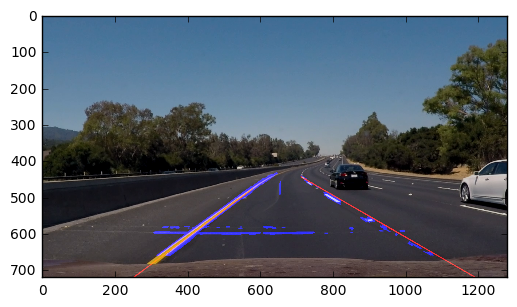

In [234]:
challenge_output = 'extra.mp4'
#clip2 = VideoFileClip('challenge.mp4').set_duration(3.7,change_end=True)
clip2 = VideoFileClip('challenge.mp4')
#clip2 = VideoFileClip('challenge.mp4').cutout(3.8,3.9)
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)